Una serie temporal es un conjunto de observaciones registradas en el tiempo.

Muchas veces, al analizar series temporales nuestro objetivo principal consiste en modelizar la serie, es decir, en construir un modelo que permita identificar y explicar un patrón de comportamiento a partir del cual realizar predicciones. Sin embargo, uno de los mayores problemas - si no el mayor - de esta disciplina estadística consiste en que no existe una sola forma de modelizar ni una técnica que sea la mejor en todos los casos. 

Específicamente, en este cuaderno, vamos a mostrar como pasar automáticamente de unos datos a un modelo ARIMA: a partir de una serie real, obtendremos un modelo ARIMA, analizaremos la bondad del ajuste del modelo y realizaremos una predicción. Todo ello, lo haremos con R. Asimismo, explicaremos lo que son los modelos ARIMA sin entrar en muchos detalles sobre la especificación y estimación del modelo.

###**¿Qué son los modelos ARIMA?**

Los modelos ARIMA son modelos paramétricos que tratan de caracterizar la serie en base a la interrelación temporal de sus elementos.

Para explicar esto más pormenorizadamente debemos acudir al propio nombre: **ARIMA = Auto-Regressive Integrated Moving Average = Autorregresivo Integrado de Medias Móviles**. Es decir, los modelos ARIMA tienen una parte autorregresiva (AR), otra parte de medias móviles (MA) y están integrados (I). Los modelos autorregresivos y los de medias móviles los tratamos más a fondo en otro ***cuaderno***, pero de manera resumida consisten en:

* AR(p): un modelo **autorregresivo** de orden *p* expresa cada observación de la serie temporal en función de su pasado hasta el retardo (momento en el pasado) *p* y la pertubación/error en el momento *t*:
\begin{align}
Y_t = \phi_1Y_{t-1} + \phi_2Y_{t-2} +\ ... \ + \phi_pY_{t-p} + a_t \ \ \ \  con\ \ \ \  a_t \sim RB(0, \sigma^2)
\end{align}
$Y_t$: observación en el instante *t*, el momento presente.

  RB: Ruido Blanco: fluctuación aleatoria de la serie, con media cero, varianza constante y errores no correlacionados.
\begin{align}
\end{align}
* MA(q): un modelo de **medias móviles** de orden *q* expresa cada observación de la serie temporal en función de la perturbación en el momento *t* y del pasado de la perturbación hasta el retardo *q*:
\begin{align}
Y_t = a_t - \theta_1a_{t-1} - \theta_2a_{t-2} -\ ... \ - \theta_qa_{t-q}
\end{align}
\begin{align}
\end{align}
* I(d): un proceso estocástico (serie temporal) es integrado de orden *d* si no es estacionario pero su diferencia de orden *d* sigue un proceso ARMA estacionario e invertible. Así, el orden de integración del proceso, *d*, es el número de diferencias que hay que tomar para conseguir la estacionariedad en media. Las condiciones de estacionariedad e invertibilidad las tratamos en otro ***cuaderno***. La idea que nos debemos quedar en este caso es que *d* es el número de diferencias de la serie que debemos tomar para poder modelizar nuestros datos según la metodología ARIMA. Tomar una diferencia consiste en restar a cada observación, la observación anterior.

Por lo tanto, una serie que sigue un modelo $ARIMA(p,d,q)$ es aquella que es estacionaria en media (porque es integrada de orden *d*), tiene una parte autorregresiva (depende de las observaciones pasadas hasta el momento *p*) y otra de medias móviles (depende de la perturbación presente y de las pasadas hasta el momento *q*):
\begin{align}
\Delta^d Y_t = \phi_1Y_{t-1} + \phi_2Y_{t-2} +\ ... \ + \phi_pY_{t-p} \ \ +\ \  a_t - \theta_1a_{t-1} - \theta_2a_{t-2} -\ ... \ - \theta_qa_{t-q}
\end{align}
\begin{align}
\end{align}
En la actualidad, los modelos ARIMA llevan la denominación más genérica de SARIMAX (*Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors*), esto es, permiten la existencia de componentes estacionales y la incorporación de terceras variables al análisis. La componente estacional, que se explica en este otro [cuaderno](https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/Casos_de_uso_R/Descomposici%C3%B3n%20manual%20de%20una%20Serie%20Temporal%20en%20R.ipynb), puede tener sus propios parámetros *p*, *d* y *q*, pero, para diferenciarlos de los anteriores, los escribimos en mayúsucula. De esta forma, ampliamos el modelo a $SARIMAX(p,d,q)(P,D,Q)_s$ ($ _s$ es la periodicidad estacional: si la estacionalidad es trimestral: $ _s = 4$; si es mensual $ _s = 12$, etc.).

###**Metodología *Box-Jenquins***

La **metodología *Box-Jenquins*** es, probablemente, la metodología más utilizada para determinar el proceso ARIMA que ha podido generar una serie temporal. Dicha metodología está formada por cuatro etapas:
1. **Identificación** de los órdenes (*p*, *d*, *q*, *P*, *D*, *Q*) del modelo.
2. **Estimación** de los parámetros $\phi$ y $θ$ (mediante Mínimos Cuadrados o Máxima Verosimilitud).
3. **Validación** del modelo propuesto: realización de distintos contrastes de hipótesis para evaluar la adecuación de los modelos estimados a los datos. Principalmente,  se contrasta si: 1) las estimaciones de los coeficientes son significativas y cumplen las condiciones de estacionariedad e invertibilidad; y 2) si los residuos del modelos son ruido blanco.
4. **Predicción** en base al modelo validado.

Asimismo, esta metodología se basa, fundamentalmente, en dos principios:
* Selección del modelo de manera iterativa: suelen identificarse distintos modelos posibles siendo el que presenta un mejor ajuste a los datos el que finalmente se elija. Por ello, tras cada etapa es posible rehacer las etapas anteriores.
* Principio de parsimonia: ante dos o más modelos con un mismo ajuste, nos debemos quedar con aquel que tiene menor número de parámetros, es decir, con el modelo más sencillo posible.

En este cuaderno, aprovechando la potencialidad de R, vamos a ajustar nuestros datos automáticamente a un modelo ARIMA mediante la función `auto.arima()` de la librería `forecast`. Esto implica que las etapas de identificación y estimación las realizará R automáticamente, y desarrollaremos las etapas de validación y predicción.

###**Librerías a utilizar**

En este cuaderno vamos a emplear las siguientes librerías:

In [ ]:
#Librería muy utilizada para el manejo de dataframes (en este caso, por ejemplo, nos permitirá renombrar columnas)
library(dplyr)
#Librería para la estimación de modelos ARIMA:
install.packages("forecast")
library(forecast)
#Para el test de significación de los coeficientes:
library(lmtest)
#Para los tests de heterocedasticidad residual:
install.packages("aTSA")
library(aTSA)
install.packages("FinTS")
library(FinTS)
#Para el test de normalidad de Jarque-Bera:
install.packages("tseries")
library(tseries)

###**Datos**
Para ejemplificar cómo pasar de los datos a un modelo ARIMA vamos a utilizar tres ejemplos:
1. Serie de los datos del PIB a precios de mercado por la vía de la Demanda sin ajuste de estacionalidad y calendario. Periodicidad trimestral entre el primer trimestre de 1995 y el último de 2019.
2. Serie de los datos del PIB a precios de mercado por la vía de la Demanda ajustadas la estacionalidad y los efectos de calendario. Periodicidad trimestral entre el primer trimestre de 1995 y el último de 2019.
3. Serie de los datos del IPC (base 2021) de los Equipos audiovisuales, fotográficos y de procesamiento de información. Periodicidad mensual entre enero de 2002 y diciembre de 2021.

Los datos de PIB pueden obtenerse de este [enlace](https://ine.es/jaxiT3/Tabla.htm?t=30680&L=0) y los del IPC de este [otro](https://ine.es/jaxiT3/Tabla.htm?t=50903&L=0).

Una vez nos los hayamos descargado en formato *.csv* separado por **;** , los cargamos en el cuaderno de Colab de manera manual. En este [cuaderno](https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/Pildoras/Subir%20archivos%20a%20Colab%20desde%20repositorio%20local%20o%20Google%20Drive%20usando%20Python%20o%20R.ipynb) se explica cómo hacer la subida de datos a un cuaderno de Colab.

(Para facilitar el seguimiento del cuaderno hemos cambiado el nombre del *.csv* con los datos de PIB a **Datos_PIB**, y el *.csv* con los datos del IPC a **Datos_IPC_Tecnologia**).


En primer lugar, leemos el archivo con los datos de PIB:

In [ ]:
datos_PIB <- read.csv("Datos_PIB.csv", sep=";", dec=",", fileEncoding="latin1")
#La opción encoding = "latin-1" la utilizamos para evitar un problema relacionado con la codificación UTF-8
datos_PIB <- datos_PIB[, c("Tipo.de.dato", "Periodo", "Total")]
#Nos quedamos solamente con las columnas más relevantes
datos_PIB <- rename(datos_PIB, PIB_Millones_de_euros = Total)
#Convertimos la columna PIB_Millones_de_euros en decimal (de primeras es de tipo string):
datos_PIB$PIB_Millones_de_euros <- as.double(datos_PIB$PIB_Millones_de_euros)
head(datos_PIB)
tail(datos_PIB)

,Tipo.de.dato,Periodo,PIB_Millones_de_euros
,<chr>,<chr>,<dbl>
1,Datos no ajustados de estacionalidad y calendario,2019T4,324.228
2,Datos no ajustados de estacionalidad y calendario,2019T3,305.611
3,Datos no ajustados de estacionalidad y calendario,2019T2,315.507
4,Datos no ajustados de estacionalidad y calendario,2019T1,299.029
5,Datos no ajustados de estacionalidad y calendario,2018T4,314.974
6,Datos no ajustados de estacionalidad y calendario,2018T3,296.887


,Tipo.de.dato,Periodo,PIB_Millones_de_euros
,<chr>,<chr>,<dbl>
195,Datos ajustados de estacionalidad y calendario,1996T2,121.212
196,Datos ajustados de estacionalidad y calendario,1996T1,119.460
197,Datos ajustados de estacionalidad y calendario,1995T4,117.799
198,Datos ajustados de estacionalidad y calendario,1995T3,115.628
199,Datos ajustados de estacionalidad y calendario,1995T2,114.401
200,Datos ajustados de estacionalidad y calendario,1995T1,112.760


In [ ]:
cat("El número de filas del dataframe datos_PIB es", nrow(datos_PIB), "y el de columnas es", ncol(datos_PIB))

El número de filas del dataframe datos_PIB es 200 y el de columnas es 3

Si nos fijamos en la columna `Tipo.de.dato`, vemos que las primeras observaciones/filas contienen los datos de PIB **NO** ajustados a la estacionalidad y a posibles efectos de calendario, mientras que las últimas contienen los datos **SÍ** ajustados. Por ello, debemos dividir este `dataframe` en dos, para tener, por un lado, los datos no ajustados y, por otro, los ajustados:

In [ ]:
#Para el dataframe con los datos del PIB NO ajustados, nos vamos a quedar con aquellas filas que en la columna "Tipo de dato" ponga "Datos no ajustados de estacionalidad y calendario":
datos_PIB_NO_ajustados <- datos_PIB[datos_PIB$Tipo.de.dato == "Datos no ajustados de estacionalidad y calendario", ]
#Ordenamos las filas de manera cronológica:
datos_PIB_NO_ajustados <- datos_PIB_NO_ajustados[order(datos_PIB_NO_ajustados$Periodo), ]
head(datos_PIB_NO_ajustados)

,Tipo.de.dato,Periodo,PIB_Millones_de_euros
,<chr>,<chr>,<dbl>
100,Datos no ajustados de estacionalidad y calendario,1995T1,109.165
99,Datos no ajustados de estacionalidad y calendario,1995T2,116.633
98,Datos no ajustados de estacionalidad y calendario,1995T3,112.398
97,Datos no ajustados de estacionalidad y calendario,1995T4,122.392
96,Datos no ajustados de estacionalidad y calendario,1996T1,115.776
95,Datos no ajustados de estacionalidad y calendario,1996T2,123.286


In [ ]:
cat("El número de filas del dataframe datos_PIB_NO_ajustados es", nrow(datos_PIB_NO_ajustados), "y el de columnas es", ncol(datos_PIB_NO_ajustados))

El número de filas del dataframe datos_PIB_NO_ajustados es 100 y el de columnas es 3

In [ ]:
#Para el dataframe con los datos del PIB NO ajustados, nos vamos a quedar con aquellas filas que en la columna "Tipo de dato" ponga "Datos no ajustados de estacionalidad y calendario":
datos_PIB_SI_ajustados <- datos_PIB[datos_PIB$Tipo.de.dato == "Datos ajustados de estacionalidad y calendario", ]
#Ordenamos las filas de manera cronológica:
datos_PIB_SI_ajustados <- datos_PIB_SI_ajustados[order(datos_PIB_SI_ajustados$Periodo), ]
head(datos_PIB_SI_ajustados)

,Tipo.de.dato,Periodo,PIB_Millones_de_euros
,<chr>,<chr>,<dbl>
200,Datos ajustados de estacionalidad y calendario,1995T1,112.760
199,Datos ajustados de estacionalidad y calendario,1995T2,114.401
198,Datos ajustados de estacionalidad y calendario,1995T3,115.628
197,Datos ajustados de estacionalidad y calendario,1995T4,117.799
196,Datos ajustados de estacionalidad y calendario,1996T1,119.460
195,Datos ajustados de estacionalidad y calendario,1996T2,121.212


In [ ]:
cat("El número de filas del dataframe datos_PIB_SI_ajustados es", nrow(datos_PIB_SI_ajustados), "y el de columnas es", ncol(datos_PIB_SI_ajustados))

El número de filas del dataframe datos_PIB_SI_ajustados es 100 y el de columnas es 3

Finalmente leemos el archivo con los datos del IPC. En este caso, no habría que dividir el `dataframe`:

In [ ]:
datos_IPC_Tecnologia <- read.csv("Datos_IPC_Tecnologia.csv", sep=";", dec=",", fileEncoding="latin1")
#La opción encoding = "latin-1" la utilizamos para evitar un problema relacionado con la codificación UTF-8
datos_IPC_Tecnologia <- datos_IPC_Tecnologia[, c("Periodo", "Total")]
#Nos quedamos solamente con las columnas más relevantes
datos_IPC_Tecnologia <- rename(datos_IPC_Tecnologia, IPC_Tecnologia = Total)
#Ordenamos los datos cronológicamente:
datos_IPC_Tecnologia <- datos_IPC_Tecnologia[order(datos_IPC_Tecnologia$Periodo), ]
head(datos_IPC_Tecnologia)

,Periodo,IPC_Tecnologia
,<chr>,<dbl>
240,2002M01,493.091
239,2002M02,490.112
238,2002M03,487.236
237,2002M04,484.317
236,2002M05,477.891
235,2002M06,477.454


###**Ajustar un modelo ARIMA automáticamente**

Una vez hemos cargado todos los datos, vamos a proceder al ajuste automático a modelos ARIMA de las tres series temporales:

####**Serie temporal PIB con datos NO ajustados**

######**Creamos una serie temporal a partir de los datos**

Vamos a dividir nuestra serie temporal en dos conjuntos de datos: `entrenamiento` y `test`. El primero nos servirá para "entrenar" el modelo y realizar la predicción de 2019, e irá hasta diciembre de 2018; y el segundo, formado por los datos de 2019, nos permitirá comparar los datos reales de ese año con los predichos:

In [ ]:
#Datos hasta 2018 incluido (hasta la fila 96):
entrenamiento_datos_PIB_NO_ajustados_hasta_2018 <- datos_PIB_NO_ajustados[1:96,]
#Datos de 2019 (a partir de la fila 97):
test_datos_PIB_NO_ajustados_2019 = datos_PIB_NO_ajustados[97:100,]

A continuación, vamos a decirle a R que nuestros datos proceden de una serie temporal. Para ello, emplearemos la función `ts()`, que convierte nuestro `dataframe` en un objeto `time series`.

In [ ]:
#Nos quedamos solo con la columna PIB_Millones_de_euros:
Serie_PIB_NO_ajustados_hasta_2018 <- entrenamiento_datos_PIB_NO_ajustados_hasta_2018[ ,c("PIB_Millones_de_euros")]
#Convertimos el dataframe en un objeto serie temporal: 
Serie_PIB_NO_ajustados_hasta_2018 <- ts(Serie_PIB_NO_ajustados_hasta_2018,
                                        start = c(1995, 1), #Fecha de inicio de los datos (primer trimestre de 1995)
                                        frequency = 4) #Periodicidad trimestral (4 trimestres en un año)
Serie_PIB_NO_ajustados_hasta_2018

,Qtr1,Qtr2,Qtr3,Qtr4
1995,109.165,116.633,112.398,122.392
1996,115.776,123.286,120.174,129.967
1997,121.938,130.471,127.175,139.684
1998,130.480,140.009,136.461,149.043
1999,141.050,149.831,145.954,158.888
2000,153.800,162.872,158.993,172.186
2001,166.581,176.446,171.995,185.971
2002,177.793,189.754,183.547,198.458
2003,190.914,202.759,196.507,212.086
2004,203.839,217.083,210.474,228.041


In [ ]:
#Nos quedamos solo con la columna PIB_Millones_de_euros:
Serie_PIB_NO_ajustados_2019 <- test_datos_PIB_NO_ajustados_2019[ ,c("PIB_Millones_de_euros")]
#Convertimos el dataframe en un objeto serie temporal: 
Serie_PIB_NO_ajustados_2019 <- ts(Serie_PIB_NO_ajustados_2019,
                                  start = c(2019, 1), #Fecha de inicio de los datos (primer trimestre de 2019)
                                  frequency = 4) #Periodicidad trimestral (4 trimestres en un año)
Serie_PIB_NO_ajustados_2019

,Qtr1,Qtr2,Qtr3,Qtr4
2019,299.029,315.507,305.611,324.228


Graficamos la serie temporal:

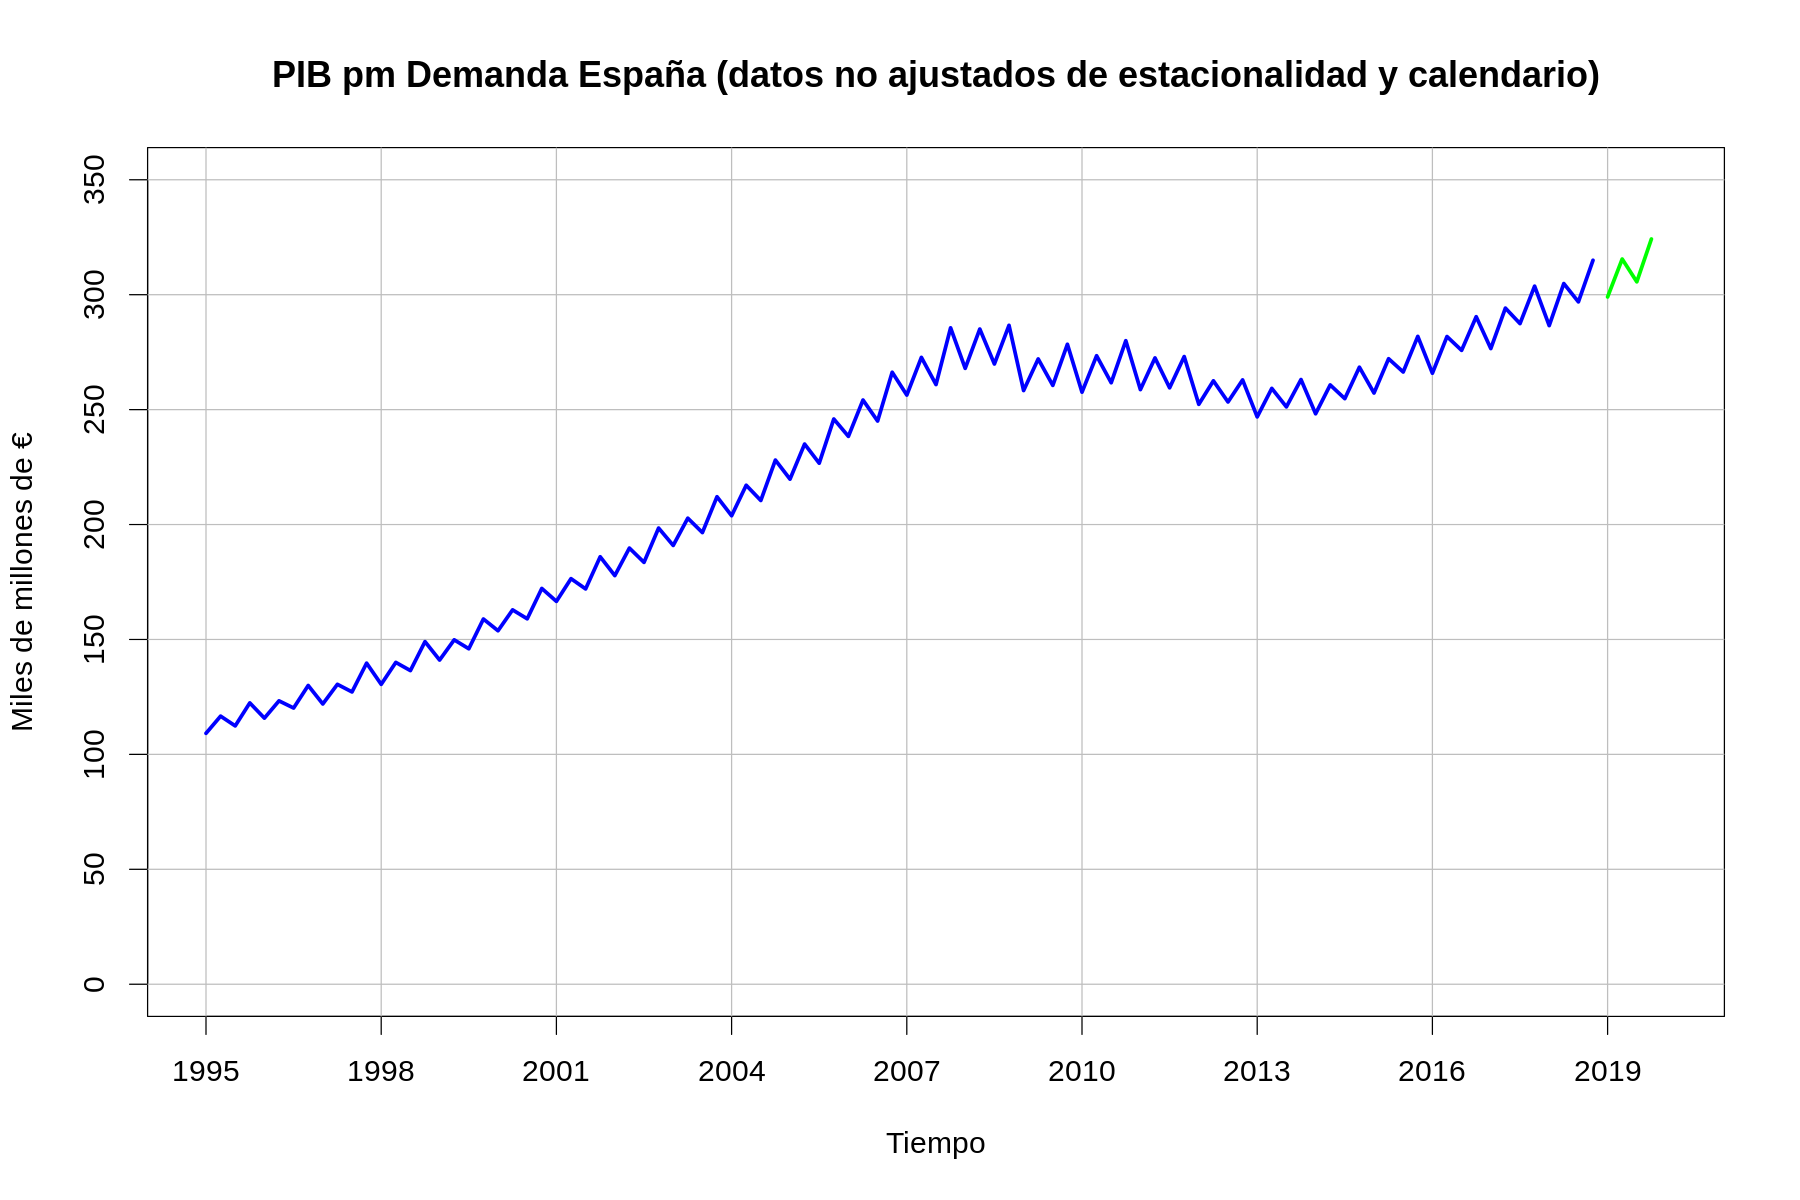

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=10)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Miles de millones de €", 
     main="PIB pm Demanda España (datos no ajustados de estacionalidad y calendario)", #Título del gráfico
     xlim = c(1995, 2020),
     ylim = c(0, 350),
     xaxp = c(1995, 2019, 8)) #Etiquetas del eje X: de 1995 a 2019 en 8 saltos

#Añadimos una rejilla:
abline(h = c(0, 50, 100, 150, 200, 250, 300, 350), #Líneas horizontales de la rejilla
       v = c(1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016, 2019), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos la serie temporal hasta 2018:
lines(Serie_PIB_NO_ajustados_hasta_2018,
      col="blue", #Color azul
      lwd=3) #Anchura de la línea

#Graficamos la serie de 2019:
lines(Serie_PIB_NO_ajustados_2019,
      col="green", lwd=3)

#Es importante seguir este orden: 1) figura vacía, 2) rejilla y 3) serie temporal, para evitar que las líneas de rejilla aparezcan por encima de la serie temporal

Vemos que la serie presenta estacionalidad, ya que parece seguir un patrón similar de subidas y bajadas todos los años.

######**Utilizamos `auto.arima()`**

In [ ]:
ARIMA_Serie_PIB_NO_ajustado = auto.arima(Serie_PIB_NO_ajustados_hasta_2018,
                                         trace=TRUE, #Para que nos salgan todos los modelos que prueba internamente
                                         seasonal=TRUE, #Especificamos que tiene estacionalidad
                                         ic="aic") #Le indicamos que utilice el AIC de los modelos para decidir cúal es el mejor


 ARIMA(2,1,2)(1,1,1)[4]                    : 425.5654
 ARIMA(0,1,0)(0,1,0)[4]                    : 433.7874
 ARIMA(1,1,0)(1,1,0)[4]                    : 437.0992
 ARIMA(0,1,1)(0,1,1)[4]                    : 437.3937
 ARIMA(2,1,2)(0,1,1)[4]                    : 426.9619
 ARIMA(2,1,2)(1,1,0)[4]                    : 427.9426
 ARIMA(2,1,2)(2,1,1)[4]                    : 427.3579
 ARIMA(2,1,2)(1,1,2)[4]                    : 427.317
 ARIMA(2,1,2)(0,1,0)[4]                    : 425.6737
 ARIMA(2,1,2)(0,1,2)[4]                    : 427.5228
 ARIMA(2,1,2)(2,1,0)[4]                    : 428.09
 ARIMA(2,1,2)(2,1,2)[4]                    : 431.9565
 ARIMA(1,1,2)(1,1,1)[4]                    : 427.0847
 ARIMA(2,1,1)(1,1,1)[4]                    : 423.8631
 ARIMA(2,1,1)(0,1,1)[4]                    : 425.207
 ARIMA(2,1,1)(1,1,0)[4]                    : 425.973
 ARIMA(2,1,1)(2,1,1)[4]                    : 425.719
 ARIMA(2,1,1)(1,1,2)[4]                    : 425.689
 ARIMA(2,1,1)(0,1,0)[4]           

In [ ]:
#Mostramos el AIC del modelo:
ARIMA_Serie_PIB_NO_ajustado$aic

[1] 423.8631

`auto.arima()` se queda con el modelo que minimiza el AIC (*Akaike Information Criteria*, un índice de bondad del ajuste de los datos al modelo)

In [ ]:
#Coeficientes estimados del modelo:
ARIMA_Serie_PIB_NO_ajustado

Series: Serie_PIB_NO_ajustados_hasta_2018 
ARIMA(2,1,1)(1,1,1)[4] 

Coefficients:
          ar1     ar2     ma1    sar1    sma1
      -0.3860  0.4235  0.4634  0.6405  -0.884
s.e.   0.2217  0.1090  0.2427  0.1678   0.123

sigma^2 = 5.624:  log likelihood = -205.93
AIC=423.86   AICc=424.86   BIC=438.93

In [ ]:
#¿Son los coeficientes estadísticamente significativos?
coeftest(ARIMA_Serie_PIB_NO_ajustado)


z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1  -0.38605    0.22166 -1.7416 0.0815761 .  
ar2   0.42346    0.10897  3.8860 0.0001019 ***
ma1   0.46344    0.24271  1.9094 0.0562090 .  
sar1  0.64051    0.16777  3.8179 0.0001346 ***
sma1 -0.88402    0.12298 -7.1882 6.564e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Según `auto.arima()` el modelo que mejor ajusta a los datos es un $ARIMA(2,1,1)(1,1,1)_4$:
\begin{align}
Δ^1_4Y_t = -0,38605Y_{t-1}+0,42346Y_{t-2}+a_t+0,46344a_{t-1}+0,64051Y_{t-4}-0,88402a_{t-4}
\end{align}
Si atendemos a los $p-valores$ de los coeficientes, podemos considerar que todos son estadísticamente significativos, al menos, al nivel de significación $\alpha=0,1$.

######**Estudiamos los residuos**

El siguiente paso consiste en estudiar si los residuos se distruyen como ruido blanco (independientes, heterocedásticos y con media cero).

* Comprobemos primero si la **media residual** es cero:

In [ ]:
#Media de los residuos:
mean(ARIMA_Serie_PIB_NO_ajustado$residuals)

[1] 0.01375363

In [ ]:
#Test de la t para comprobar si la media residual es estadísticamente distinta de cero:
t.test(ARIMA_Serie_PIB_NO_ajustado$residuals)


	One Sample t-test

data:  ARIMA_Serie_PIB_NO_ajustado$residuals
t = 0.059722, df = 95, p-value = 0.9525
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.4434370  0.4709443
sample estimates:
 mean of x 
0.01375363 


Como el $p-valor = 0,9525$ es mayor que los niveles de significación habituales (0,01; 0,05; y 0,1), no podemos rechazar la hipótesis nula de que la media de los residuos es igual a cero.

* Seguimos con el estudio de la **varianza residual**:

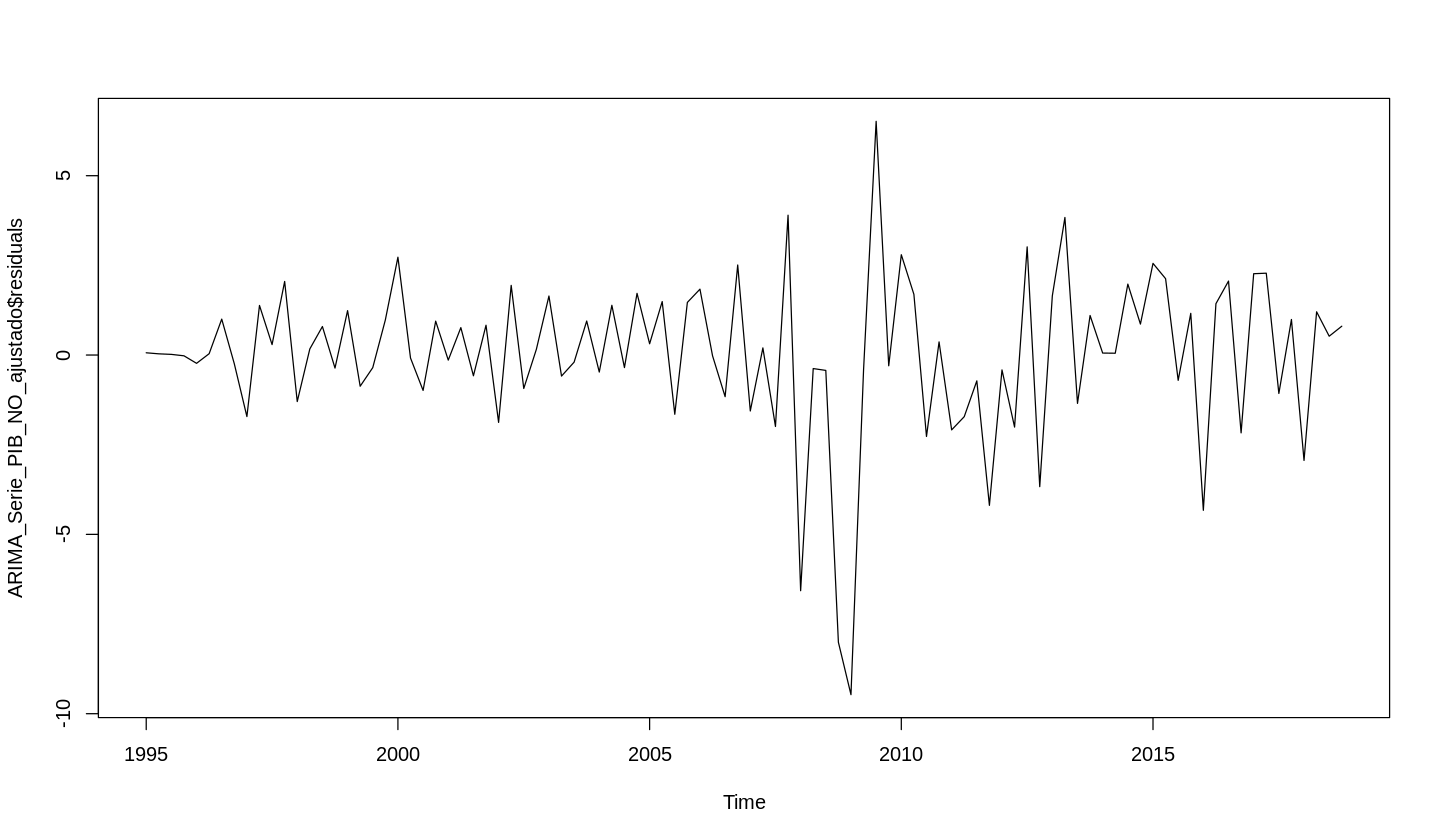

In [ ]:
options(repr.plot.width=12, repr.plot.height=7)
plot(ARIMA_Serie_PIB_NO_ajustado$residuals)

En primer lugar, al observar la varianza el gráfico de los residuos, podemos ver que no son homocedásticos (no tienen varianza constante), sino que esta aumenta - y vuelve a disminuir - en torno al inicio de la crisis económica de 2008.

Entonces, para corrobar la idea de que los residuos no son homocedásticos, es decir, de que su varianza no es constante, vamos a emplear un par de test que comprueban si existen efectos ARCH. Los modelos ARCH son modelos avanzados de series temporales que permiten modelizar series con varianza no constante, heterocedástica. Por lo tanto, si los test que vamos a usar arrojan la existencia de efectos ARCH, querrán decir que la varianza de nuestros residuos no es constante.

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order   PQ  p.value
[1,]     4 25.8 3.43e-05
[2,]     8 26.9 7.41e-04
[3,]    12 27.7 6.08e-03
[4,]    16 28.7 2.61e-02
[5,]    20 29.5 7.84e-02
[6,]    24 31.0 1.53e-01
Lagrange-Multiplier test: 
     order    LM  p.value
[1,]     4 50.15 7.41e-11
[2,]     8 17.11 1.67e-02
[3,]    12  8.71 6.49e-01
[4,]    16  5.66 9.85e-01
[5,]    20  3.81 1.00e+00
[6,]    24  2.64 1.00e+00


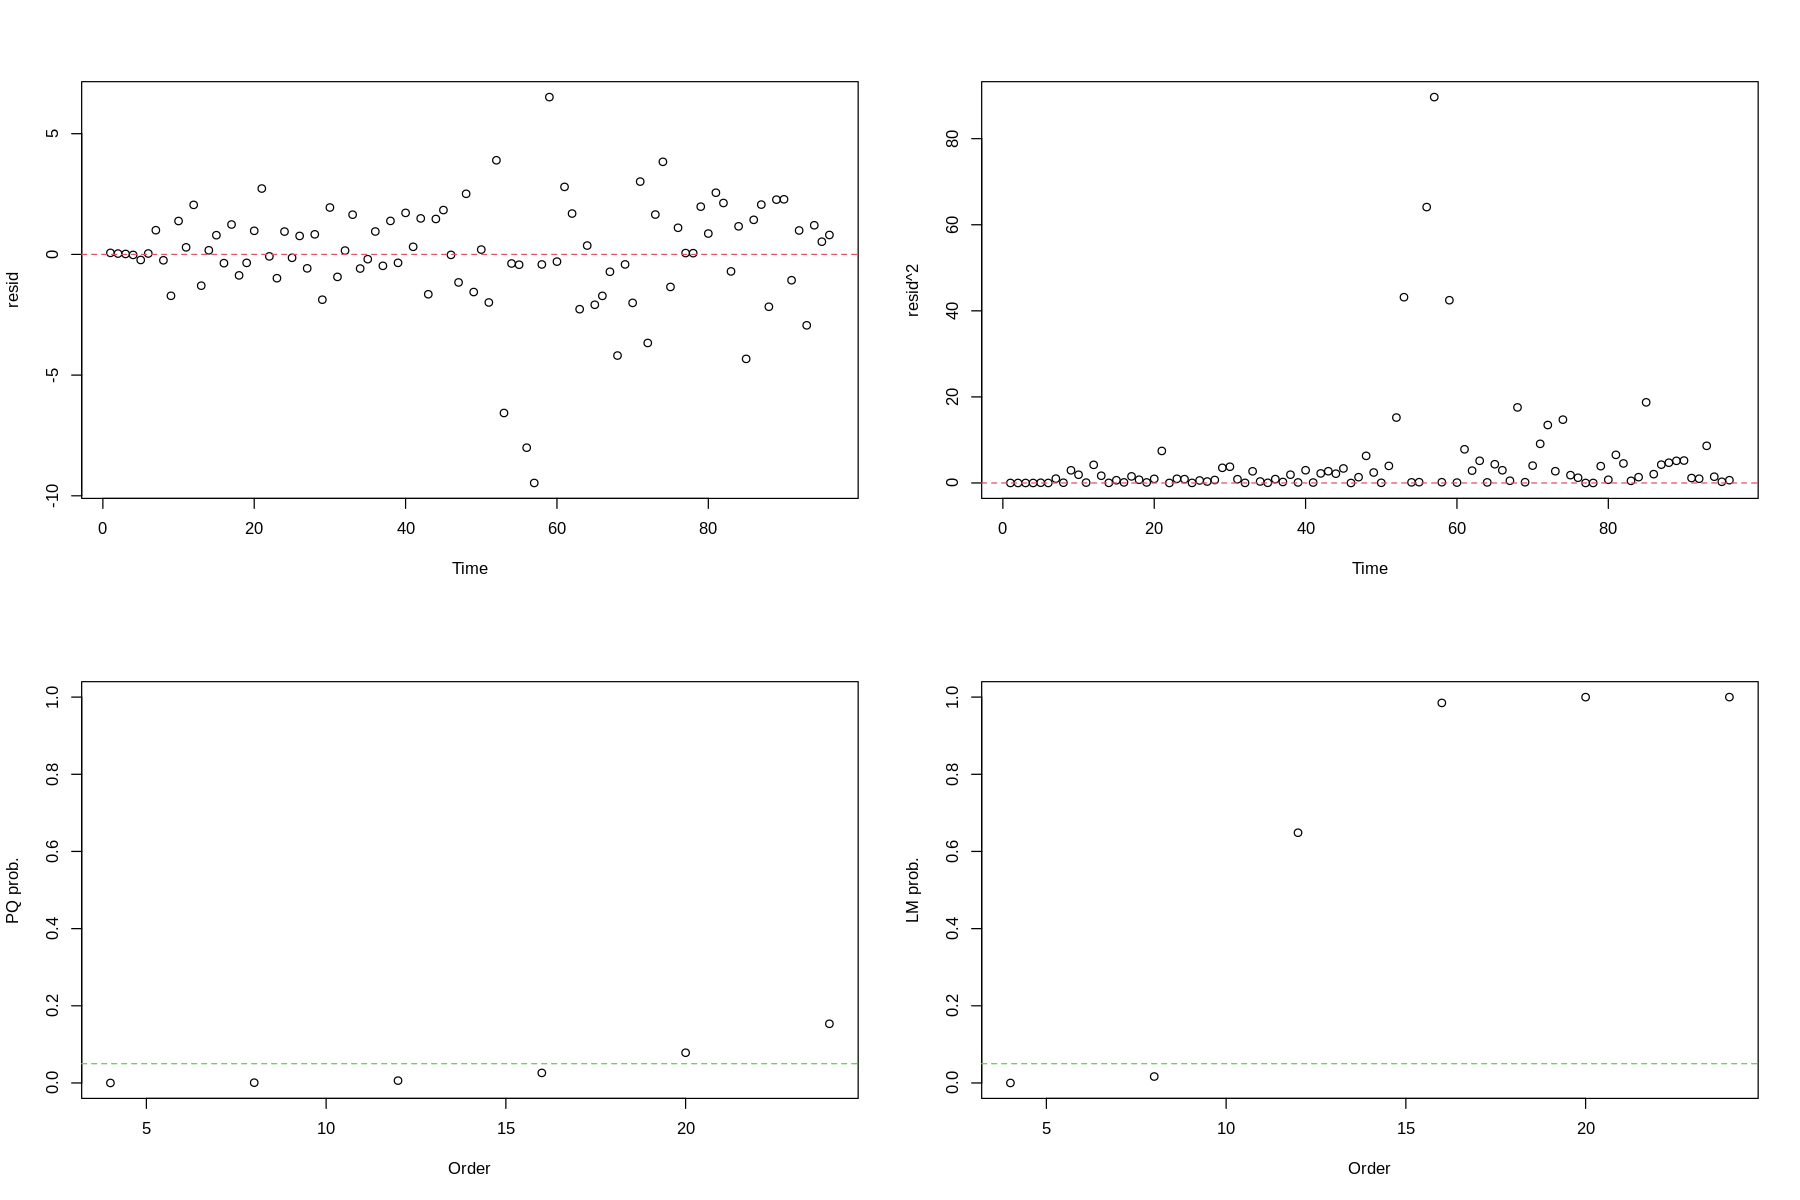

In [ ]:
#Debemos crear un objeto arima(), ya que la función arch.test() no funciona con objetos auto.arima()
Modelo_ARIMA_para_test_ARCH <- arima(Serie_PIB_NO_ajustados_hasta_2018,
                                     order=c(2,1,1), #Nuestro ARIMA era un (2,1,1)(1,1,1)
                                     seasonal=c(1,1,1),
                                     include.mean=FALSE) #Nuestro ARIMA no tenía intercepto significativo
#Sobre el anterior objeto arima(), realizamos el test:                                     
Test <- arch.test(Modelo_ARIMA_para_test_ARCH)

Nos fijamos en los gráficos:
* Esquina superior izquierda: gráfico de los residuos contra el tiempo. Es el mismo gráfico que hemos visto justo arriba y por el que ya indicamos que parecía existir varianza no constante (heterocedasticidad). El único cambio respecto al gráfico de arriba es que, en este, los puntos no están unidos. Lo ideal, para que se apreciara homocedasticidad, es que los residuos se encontraran igual de dispersos a ambos lados de la línea de puntos rojos (que indica la media residual).
* Esquina superior derecha: gráfico de los residuos al cuadrado contra el tiempo. En este caso, lo ideal sería que los puntos se encontraran sobre la línea de puntos rojos (que indica la media residual).
* Esquina inferior izquierda: gráfico con los p-valores del test de Portmanteau-Q. Lo ideal, serían que los p-valores se encontraran por debajo de la línea de puntos verdes, indicando que los efectos ARCH no son significativos en ningún retardo.
* Esquina inferior derecha: gráfico con los p-valores del test de los multiplicadores de Lagrange. Misma interpretación que para el anterior gráfico.

Por lo tanto, una vez revisados los gráficos, podemos determinar que nuestros residuos no son homocedásticos, ya que no tienen varianza constante.

De todas formas, empleamos, de nuevo, el test de los multiplicadores de Lagrange, procedente ahora de la librería `FinTS`, para volver a comprobar el resultado, atendiendo solo a un p-valor:

In [ ]:
ArchTest(ARIMA_Serie_PIB_NO_ajustado$residuals)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  ARIMA_Serie_PIB_NO_ajustado$residuals
Chi-squared = 19.248, df = 12, p-value = 0.08271


Si empleamos un nivel de significación $\alpha = 0,1$, debemos rechazar la hipótesis nula: sí existen efectos ARCH, nuestros residuos son heterocedásticos.

* A continuación, pasamos a estudiar la **independencia de los residuos**:

Para ello, emplearemos los test de Ljung-Box y Box-Pierce. En ambos casos, la hipótesis nula es la independencia residual:

In [ ]:
#Test de Ljung-Box:
Box.test(ARIMA_Serie_PIB_NO_ajustado$residuals,
         type="Ljung", #Tipo de test
         lag=30, #Número total de retardos sobre los que realizar el test
         fitdf=5) #Grados de libertad: uno por cada coeficientes del modelo (en nuestro caso: el modelo ARIMA(2,1,1)(1,1,1) tiene 5 coeficientes autorregresivos o de medias móviles: 2+1+1+1)
#Test de Box-Pierce:
Box.test(ARIMA_Serie_PIB_NO_ajustado$residuals,
         type="Box-Pierce",
         lag=30,
         fitdf=5)


	Box-Ljung test

data:  ARIMA_Serie_PIB_NO_ajustado$residuals
X-squared = 20.208, df = 25, p-value = 0.7358



	Box-Pierce test

data:  ARIMA_Serie_PIB_NO_ajustado$residuals
X-squared = 16.36, df = 25, p-value = 0.9037


Como en los dos casos, el $p-valor > 0,05$, no podemos rechazar la hipótesis nula de independencia (no correlación) de los residuos.

* Finalmente, observamos si los residuos siguen una **distribución normal**:

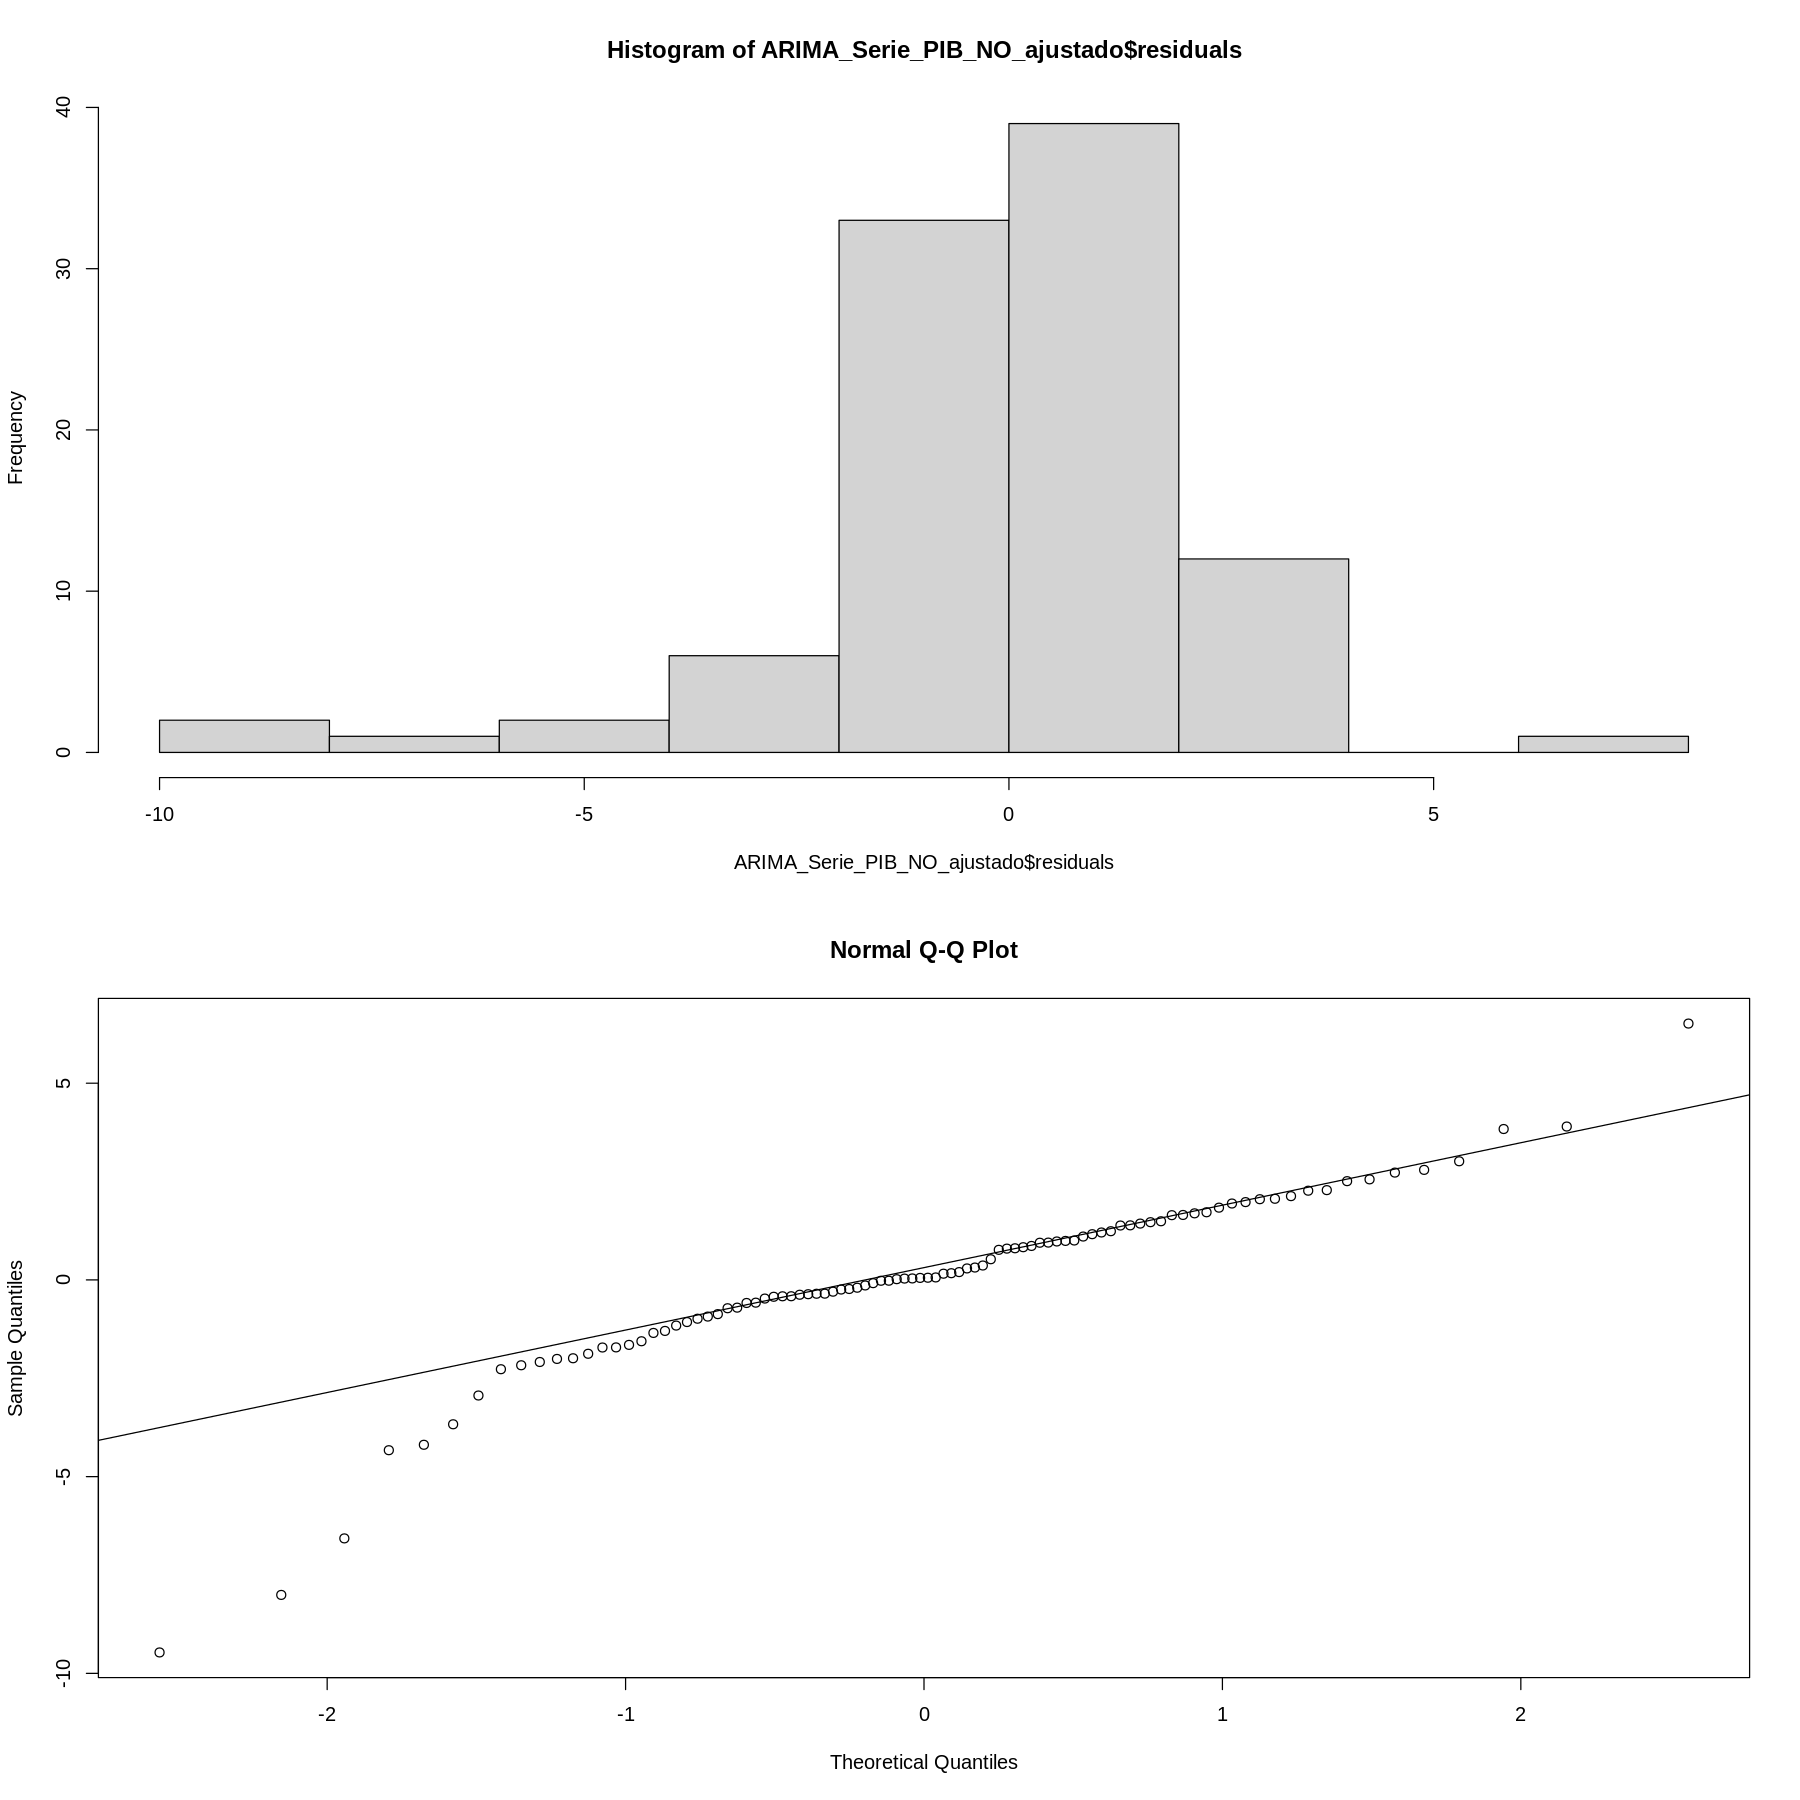

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)
par(mfrow = c(2, 1)) #Para poner los dos gráficos uno debajo del otro
#Histograma de los residuos
hist(ARIMA_Serie_PIB_NO_ajustado$residuals)
#Q-Q plot de los residuos
qqnorm(ARIMA_Serie_PIB_NO_ajustado$residuals)
qqline(ARIMA_Serie_PIB_NO_ajustado$residuals)

Por un lado, el gráfico de densidad sugiere que los residuos no se distribuyen como una $N(0,1)$. Por otro, el *Q-Q plot*, al no presentar la mayoría de puntos sobre la línea, también nos está indicando que su distribución no se asemeja mucho a la de la Normal.

La cuestión de la normalidad residual no es tan determinante como, por ejemplo, la independencia de los residuos, pero sí es recomendable. Para asegurarnos que los residuos no siguen una distribución normal, realizamos dos contrastes: el test de Shapiro-Wilk y el de Jarque-Bera:

In [ ]:
#Test de Shapiro-Wilk:
shapiro.test(ARIMA_Serie_PIB_NO_ajustado$residuals)
#Test de Jarque-Bera:
jarque.bera.test(ARIMA_Serie_PIB_NO_ajustado$residuals)


	Shapiro-Wilk normality test

data:  ARIMA_Serie_PIB_NO_ajustado$residuals
W = 0.901, p-value = 2.381e-06



	Jarque Bera Test

data:  ARIMA_Serie_PIB_NO_ajustado$residuals
X-squared = 100.89, df = 2, p-value < 2.2e-16


Como el p-valor es inferior a los niveles comunes de significación (0,1, 0,05 y 0,01), debemos rechazar la hipótesis nula de normalidad residual. Por tanto, en correspondencia con los gráficos de arriba, los residuos no siguen una distribución Normal.

######**Predecimos el siguiente año**

El último paso o la motivación última del análisis de series temporales suele ser la predicción de valores futuros. En este caso, no vamos a predecir valores futuros, sino que vamos a predecir el año 2019 para luego poder comparar la predicción con los valores reales (guardados en el conjunto de `test`) y estudiar la bondad de ajuste del modelo:

In [ ]:
#Debemos crear un objeto arima(), ya que la función forecast() no funciona con objetos auto.arima()
Modelo_ARIMA_para_predecir <- arima(Serie_PIB_NO_ajustados_hasta_2018,
                                    order=c(2,1,1), #Nuestro ARIMA era un (2,1,1)(1,1,1)
                                    seasonal=c(1,1,1),
                                    include.mean=FALSE) #Nuestro ARIMA no tenía intercepto significativo
#Predecimos el 2019 (4 trimestres) y el intervalo de confianza al 95% de las predicciones:
Prediccion_2019_PIB_NO_ajustado <- forecast(Modelo_ARIMA_para_predecir,
                                            lead=4, #Porque vamos a predecir los 4 valores siguientes
                                            output = F) #Para que no se nos imprima el resultado
#Creamos un dataframe con los resultados de la predicción para facilitar su manejo en R:
Prediccion_2019_PIB_NO_ajustado <- data.frame(Prediccion_2019_PIB_NO_ajustado)
#Nos quedamos solamente con las columnas de valores predichos y del intervalo de confianza:
Prediccion_2019_PIB_NO_ajustado <- Prediccion_2019_PIB_NO_ajustado[,c("Forecast", "Lower", "Upper")]
#Cambiamos el nombre a las columnas:
Prediccion_2019_PIB_NO_ajustado <- rename(Prediccion_2019_PIB_NO_ajustado, Valores_Predichos = Forecast, Confint_Inferior = Lower, Confint_Superior = Upper)

#Convertimos el dataframe en un objeto serie temporal: 
Prediccion_2019_PIB_NO_ajustado <- ts(Prediccion_2019_PIB_NO_ajustado,
                                      start = c(2019, 1), #Fecha de inicio de los datos (primer trimestre de 2019)
                                      frequency = 4) #Periodicidad trimestral (4 trimestres en un año)
Prediccion_2019_PIB_NO_ajustado

,Valores_Predichos,Confint_Inferior,Confint_Superior
2019 Q1,297.6690,293.1500,302.1881
2019 Q2,316.0850,309.4422,322.7278
2019 Q3,307.3398,297.9424,316.7372
2019 Q4,325.5375,314.3290,336.7459


Graficamos la serie real, la predicción y su intervalo de confianza:

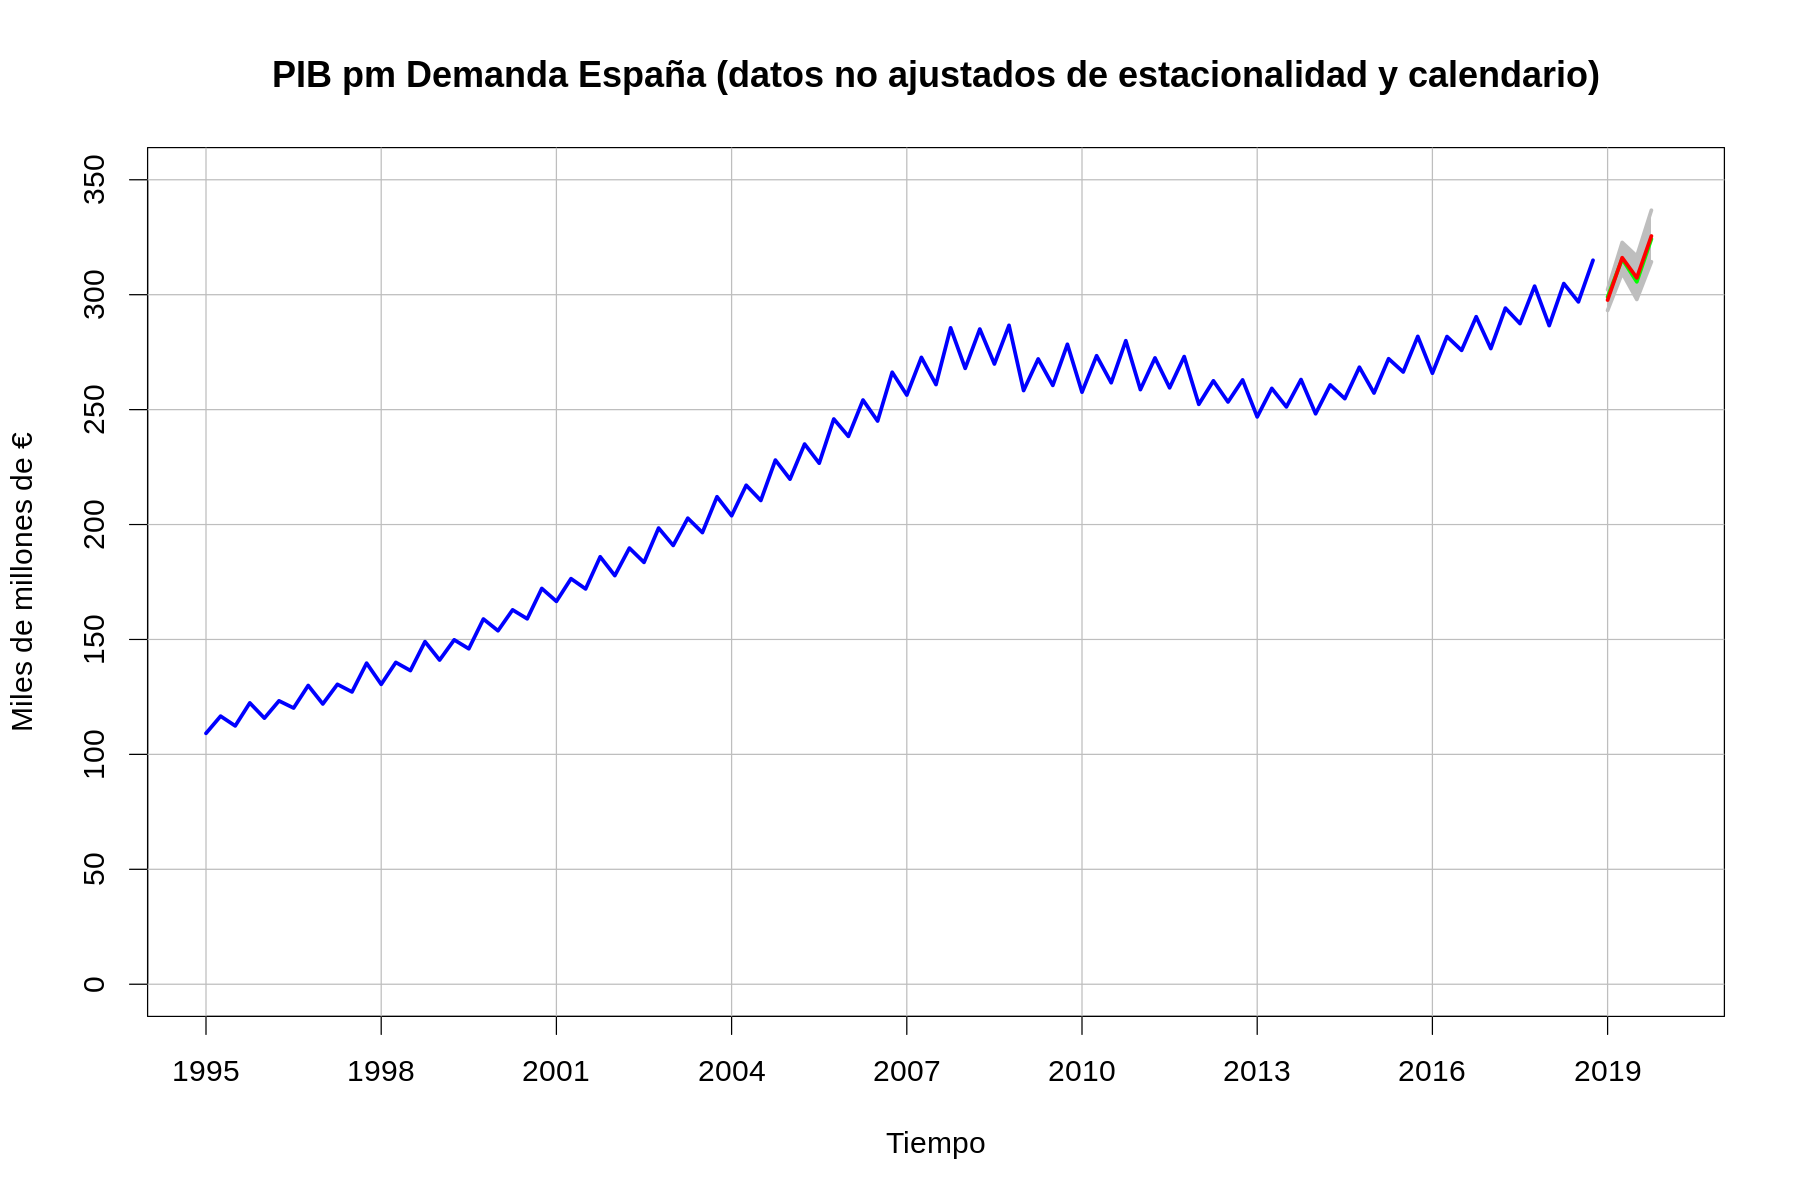

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=10)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Miles de millones de €", 
     main="PIB pm Demanda España (datos no ajustados de estacionalidad y calendario)", #Título del gráfico
     xlim = c(1995, 2020),
     ylim = c(0, 350),
     xaxp = c(1995, 2019, 8)) #Etiquetas del eje X: de 1995 a 2019 en 8 saltos

#Añadimos una rejilla:
abline(h = c(0, 50, 100, 150, 200, 250, 300, 350), #Líneas horizontales de la rejilla
       v = c(1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016, 2019), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos la serie temporal hasta 2018:
lines(Serie_PIB_NO_ajustados_hasta_2018,
      col="blue", #Color azul
      lwd=3) #Anchura de la línea

#Graficamos el intervalo de confianza de las predicciones (debemos usar la función polygon()):
tiempo <- seq(from=2019, by=1/4, length=4)
polygon(x=c(tiempo, rev(tiempo)), #Amplitud en coordenadas X del intervalo de confianza
        y=c(Prediccion_2019_PIB_NO_ajustado[, "Confint_Superior"], rev(Prediccion_2019_PIB_NO_ajustado[, "Confint_Inferior"])), #Amplitud en coordenadas Y del intervalo de confianza
        col="grey", border=NA)

#Graficamos la serie de 2019:
lines(Serie_PIB_NO_ajustados_2019,
      col="green", lwd=3)

#Graficamos las predicción
lines(Prediccion_2019_PIB_NO_ajustado[, "Valores_Predichos"],
      col="red", lwd=3)

#Es importante seguir este orden: 1) figura vacía, 2) rejilla y 3) serie temporal, para evitar que las líneas de rejilla aparezcan por encima de la serie temporal

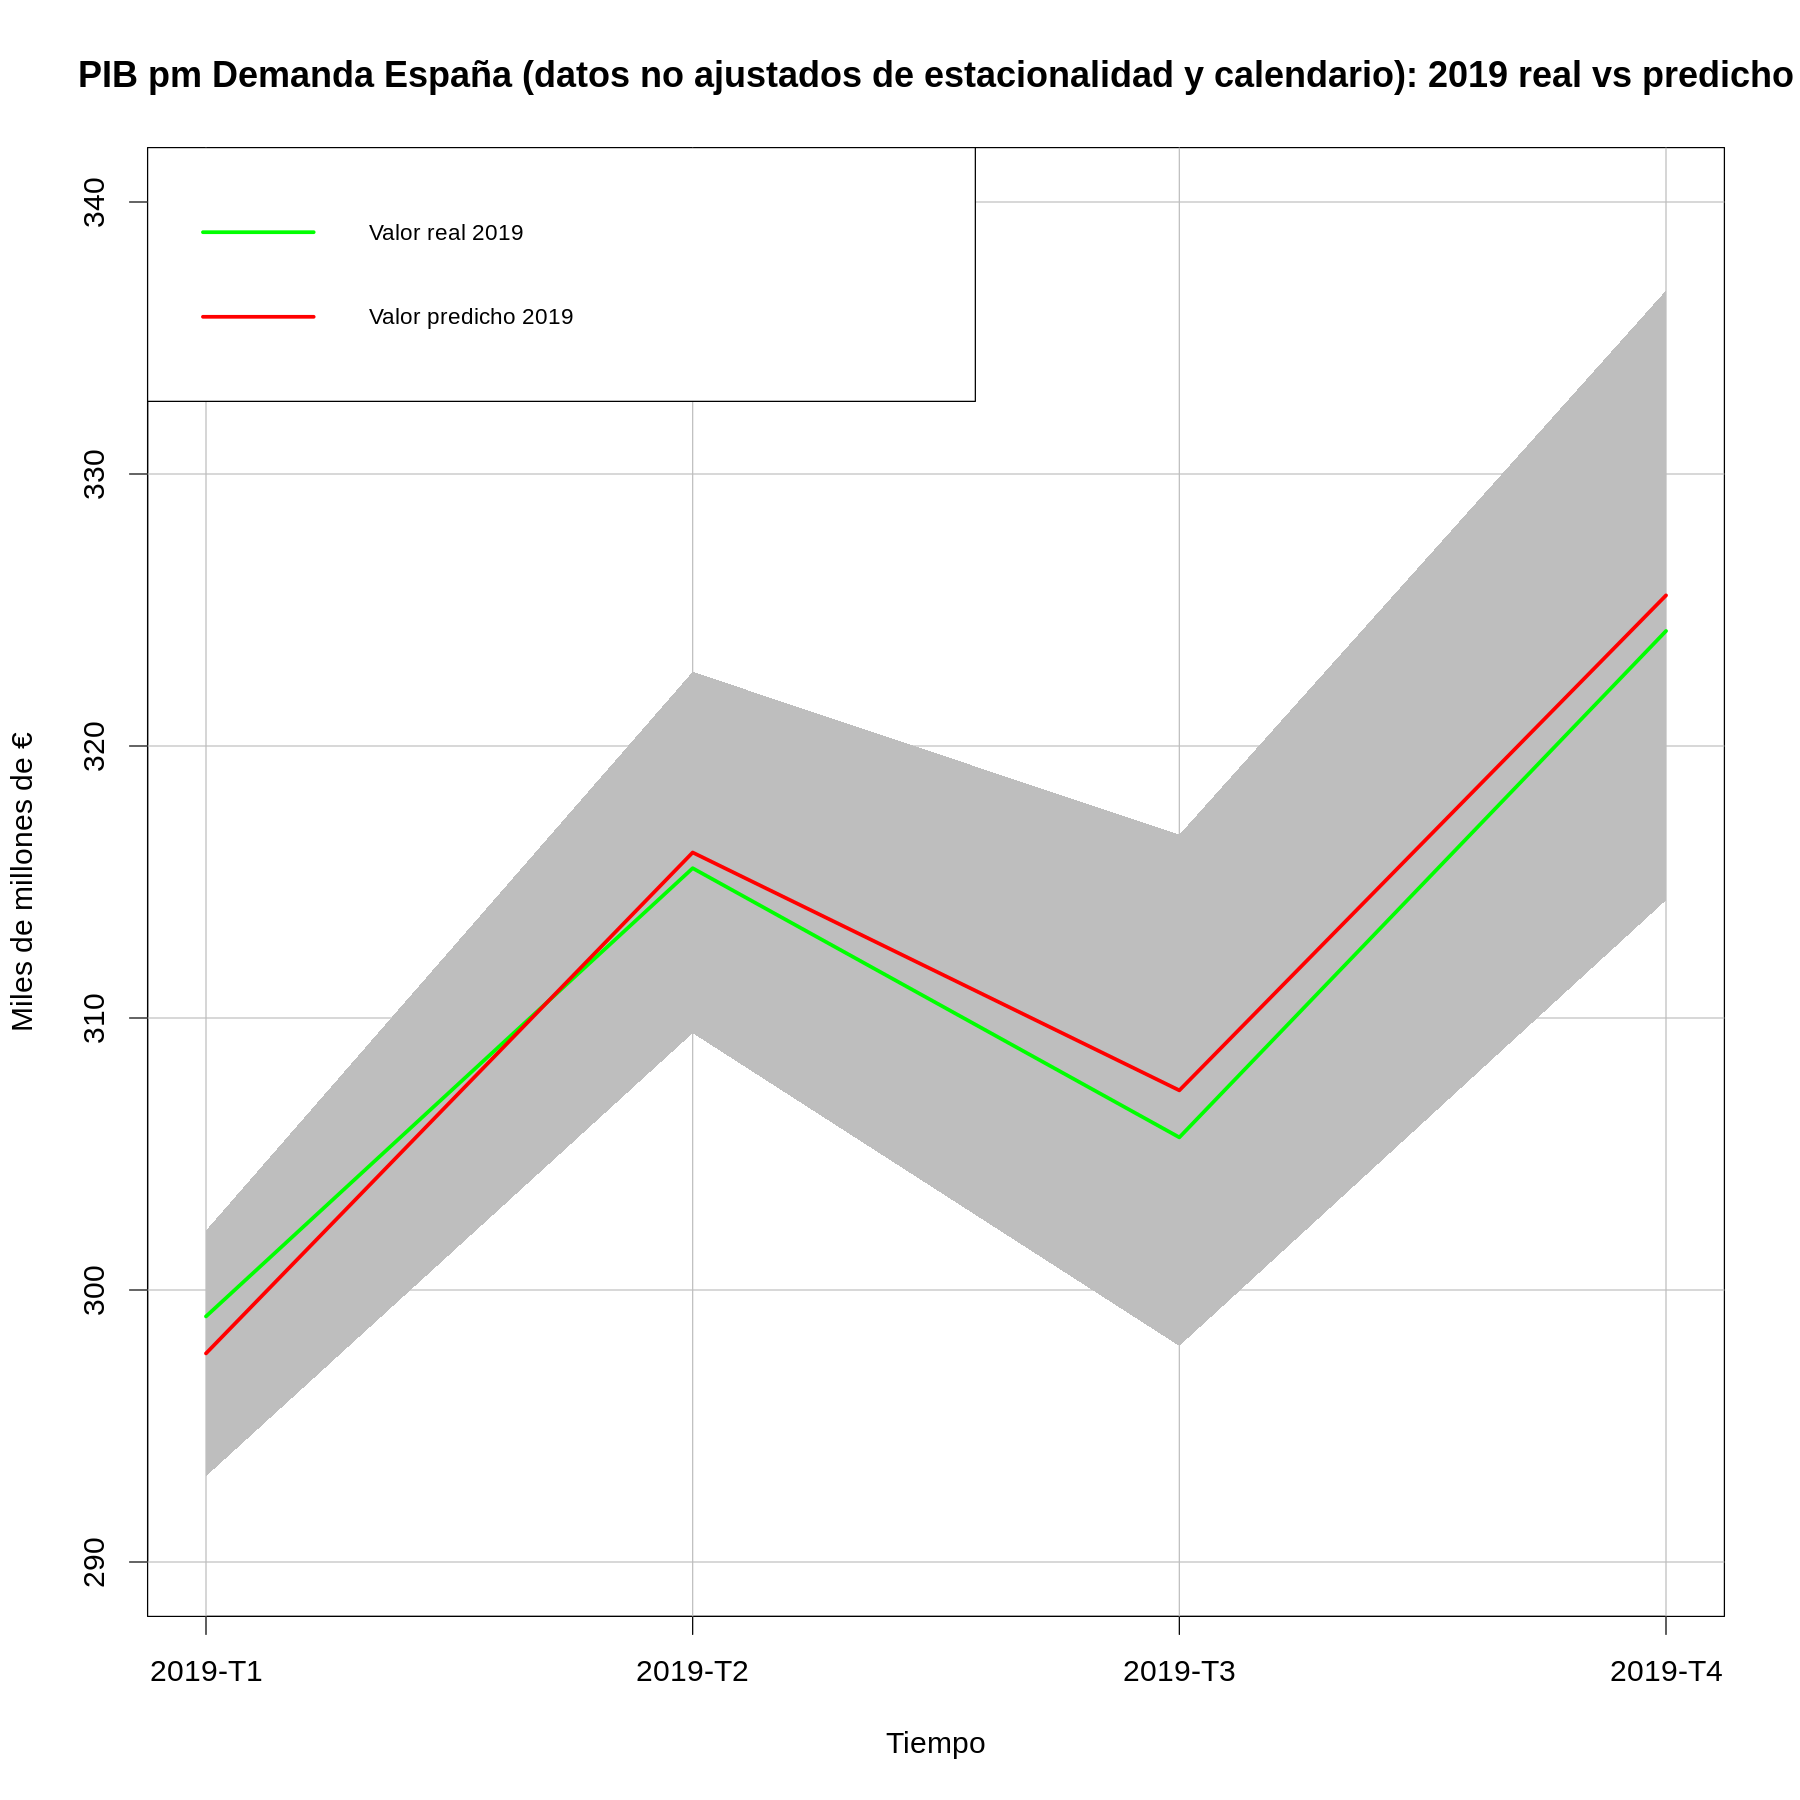

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=15)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Miles de millones de €", 
     main="PIB pm Demanda España (datos no ajustados de estacionalidad y calendario): 2019 real vs predicho",
     xlim = c(2019, 2019.75),
     ylim = c(290, 340),
     xaxt="n") #Para que este plot() no produzca ticks en el eje X

#Modificamos el eje X (eje 1) para establecer los ticks y las etiquetas donde queramos:
axis(1, at=c(2019, 2019.25, 2019.5, 2019.75), labels=c("2019-T1", "2019-T2", "2019-T3", "2019-T4"))

#Añadimos una rejilla:
abline(h = c(290, 300, 310, 320, 330, 340), #Líneas horizontales de la rejilla
       v = c(2019, 2019.25, 2019.5, 2019.75), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos el intervalo de confianza de las predicciones (debemos usar la función polygon()):
tiempo <- seq(from=2019, by=1/4, length=4) #El intervalo ocupará todo 2019 dividio en 4 partes
polygon(x=c(tiempo, rev(tiempo)), #Coordenadas X del intervalo de confianza
        y=c(Prediccion_2019_PIB_NO_ajustado[, "Confint_Superior"], rev(Prediccion_2019_PIB_NO_ajustado[, "Confint_Inferior"])), #Coordenadas Y del intervalo de confianza
        col="grey", border=NA)

#Graficamos la serie de 2019:
lines(Serie_PIB_NO_ajustados_2019,
      col="green", lwd=3)

#Graficamos las predicciones
lines(Prediccion_2019_PIB_NO_ajustado[, "Valores_Predichos"],
      col="red", lwd=3)

#Añadimos la leyenda
legend(x = "topleft",
       legend=c("Valor real 2019", "Valor predicho 2019"),
       lty=c(1, 1),
       col=c("green", "red"),
       lwd=3,
       cex=0.75)

####**Serie temporal PIB con datos SÍ ajustados**

Repetimos todo el procedimiento anterior con la serie temporal del PIB con los datos ajustados a la estacionalidad y posibles efectos de calendario.

En primer lugar, volvemos a hacer la división entre conjunto de datos de entrenamiento y conjunto de test:

In [ ]:
#Datos hasta 2018 incluido (hasta la fila 96):
entrenamiento_datos_PIB_SI_ajustados_hasta_2018 <- datos_PIB_SI_ajustados[1:96,]
#Datos de 2019 (a partir de la fila 97):
test_datos_PIB_SI_ajustados_2019 = datos_PIB_SI_ajustados[97:100,]

In [ ]:
#Nos quedamos solo con la columna PIB_Millones_de_euros:
Serie_PIB_SI_ajustados_hasta_2018 <- entrenamiento_datos_PIB_SI_ajustados_hasta_2018[ ,c("PIB_Millones_de_euros")]
#Convertimos el dataframe en un objeto serie temporal: 
Serie_PIB_SI_ajustados_hasta_2018 <- ts(Serie_PIB_SI_ajustados_hasta_2018,
                                        start = c(1995, 1), #Fecha de inicio de los datos (primer trimestre de 1995)
                                        frequency = 4) #Periodicidad trimestral (4 trimestres en un año)
Serie_PIB_SI_ajustados_hasta_2018

,Qtr1,Qtr2,Qtr3,Qtr4
1995,112.760,114.401,115.628,117.799
1996,119.460,121.212,123.582,124.949
1997,126.164,127.719,130.564,134.821
1998,134.458,137.644,139.892,143.999
1999,144.949,147.105,149.860,153.809
2000,157.400,160.232,163.227,166.992
2001,170.735,173.291,176.927,180.040
2002,182.753,186.170,188.931,191.698
2003,195.380,199.288,202.014,205.584
2004,209.190,212.367,216.525,221.355


In [ ]:
#Nos quedamos solo con la columna PIB_Millones_de_euros:
Serie_PIB_SI_ajustados_2019 <- test_datos_PIB_SI_ajustados_2019[ ,c("PIB_Millones_de_euros")]
#Convertimos el dataframe en un objeto serie temporal: 
Serie_PIB_SI_ajustados_2019 <- ts(Serie_PIB_SI_ajustados_2019,
                                  start = c(2019, 1), #Fecha de inicio de los datos (primer trimestre de 2019)
                                  frequency = 4) #Periodicidad trimestral (4 trimestres en un año)
Serie_PIB_SI_ajustados_2019

,Qtr1,Qtr2,Qtr3,Qtr4
2019,307.704,309.942,311.706,315.023


Graficamos la serie temporal:

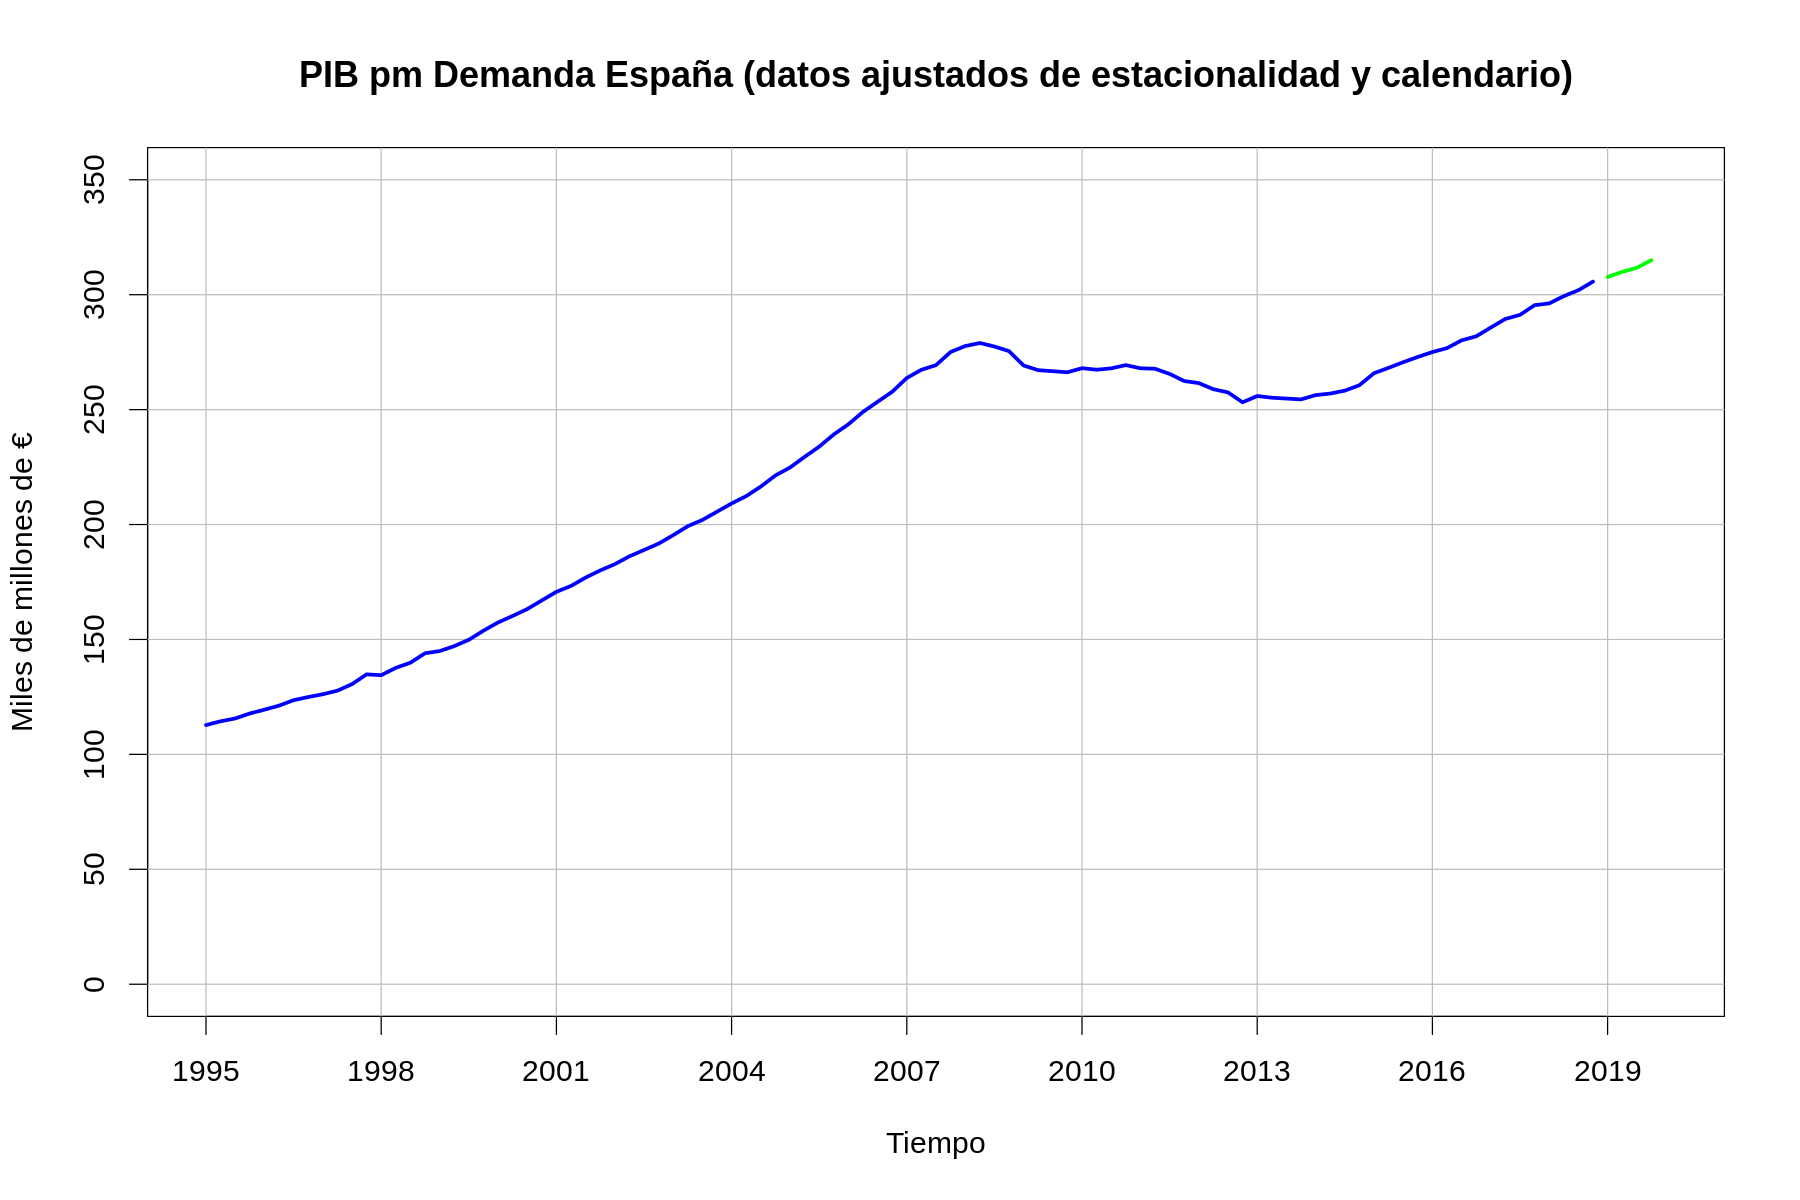

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=10)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Miles de millones de €", 
     main="PIB pm Demanda España (datos ajustados de estacionalidad y calendario)", #Título del gráfico
     xlim = c(1995, 2020),
     ylim = c(0, 350),
     xaxp = c(1995, 2019, 8)) #Etiquetas del eje X: de 1995 a 2019 en 8 saltos

#Añadimos una rejilla:
abline(h = c(0, 50, 100, 150, 200, 250, 300, 350), #Líneas horizontales de la rejilla
       v = c(1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016, 2019), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos la serie temporal hasta 2018:
lines(Serie_PIB_SI_ajustados_hasta_2018,
      col="blue", #Color azul
      lwd=3) #Anchura de la línea

#Graficamos la serie de 2019:
lines(Serie_PIB_SI_ajustados_2019,
      col="green", lwd=3)

Empleamos `auto.arima()`: en este caso, `seasonal=FALSE`, porque los datos ya han sido ajustados a la estacionalidad por el INE, es decir, ésta ya ha sido eliminada de la serie y, por eso, el gráfico anterior presenta una serie suavizada.

In [ ]:
ARIMA_Serie_PIB_SI_ajustado = auto.arima(Serie_PIB_SI_ajustados_hasta_2018,
                                         trace=TRUE, #Para que nos salgan todos los modelos que prueba internamente
                                         seasonal=FALSE, #Especificamos que no tiene estacionalidad puesto que la estacionalidad ya ha sido ajustada en esta serie
                                         ic="aic") #Le indicamos que utilice el AIC de los modelos para decidir cúal es el mejor


 ARIMA(2,2,2)                              : Inf
 ARIMA(0,2,0)                              : 386.222
 ARIMA(1,2,0)                              : 358.1236
 ARIMA(0,2,1)                              : 359.3132
 ARIMA(2,2,0)                              : 358.8644
 ARIMA(1,2,1)                              : 358.5833
 ARIMA(2,2,1)                              : Inf

 Best model: ARIMA(1,2,0)                              



In [ ]:
#Mostramos el AIC del modelo:
ARIMA_Serie_PIB_SI_ajustado$aic

[1] 358.1236

In [ ]:
#Coeficientes estimados del modelo:
ARIMA_Serie_PIB_SI_ajustado

Series: Serie_PIB_SI_ajustados_hasta_2018 
ARIMA(1,2,0) 

Coefficients:
          ar1
      -0.5215
s.e.   0.0872

sigma^2 = 2.552:  log likelihood = -177.06
AIC=358.12   AICc=358.26   BIC=363.21

In [ ]:
#¿Son los coeficientes estadísticamente significativos?
coeftest(ARIMA_Serie_PIB_SI_ajustado)


z test of coefficients:

    Estimate Std. Error z value Pr(>|z|)    
ar1 -0.52153    0.08719 -5.9815 2.21e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


En este caso, el modelo que arroja `auto.arima()` no tiene coeficientes estacionales, ya que los datos están ajustados a la estacionalidad. El modelo es, simplemente un $ARIMA(1,2,0)$, es decir, un AR(1) con dos diferencias:
\begin{align}
\Delta^2Y=-0,52153Y_{t-1}+a_t
\end{align}
Su único coeficiente autorregresivo es significativo al 99% de confianza.

A continuación, pasamos a estudiar los residuos:
* Comprobemos primero si la **media residual** es cero:

In [ ]:
#Media de los residuos:
mean(ARIMA_Serie_PIB_SI_ajustado$residuals)

[1] 0.02664987

In [ ]:
#Test de la t para comprobar si la media residual es estadísticamente distinta de cero:
t.test(ARIMA_Serie_PIB_SI_ajustado$residuals)


	One Sample t-test

data:  ARIMA_Serie_PIB_SI_ajustado$residuals
t = 0.16523, df = 95, p-value = 0.8691
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.2935522  0.3468519
sample estimates:
 mean of x 
0.02664987 


Como el $p-valor = 0,8691$ es mayor que los niveles de significación habituales (0,01; 0,05; y 0,1), no podemos rechazar la hipótesis nula de que la media de los residuos es igual a cero.

* Seguimos con el estudio de la **varianza residual**:

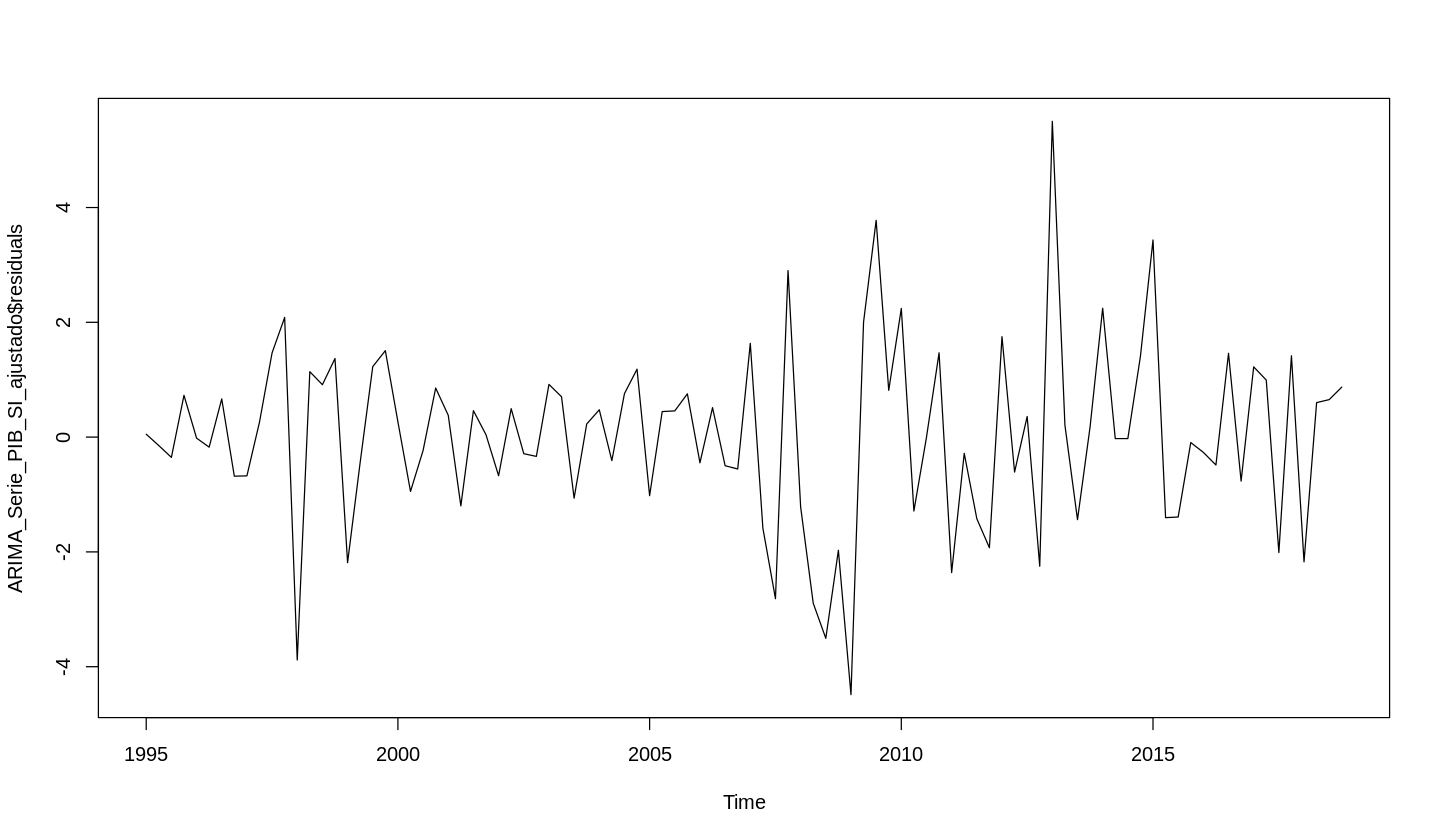

In [ ]:
options(repr.plot.width=12, repr.plot.height=7)
plot(ARIMA_Serie_PIB_SI_ajustado$residuals)

Al observar el gráfico, no se aprecia heterocedasticidad (varianza no constante) de manera tan clara a la serie con los datos del PIB no ajustados. Sin embargo, sí que parece que los residuos no tienen márgenes claros de variación.


ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order   PQ p.value
[1,]     4 11.7  0.0195
[2,]     8 16.6  0.0346
[3,]    12 18.3  0.1077
[4,]    16 25.3  0.0648
[5,]    20 27.5  0.1230
[6,]    24 28.4  0.2436
Lagrange-Multiplier test: 
     order    LM  p.value
[1,]     4 37.12 4.33e-08
[2,]     8 14.17 4.83e-02
[3,]    12  6.42 8.44e-01
[4,]    16  3.26 9.99e-01
[5,]    20  2.01 1.00e+00
[6,]    24  1.22 1.00e+00


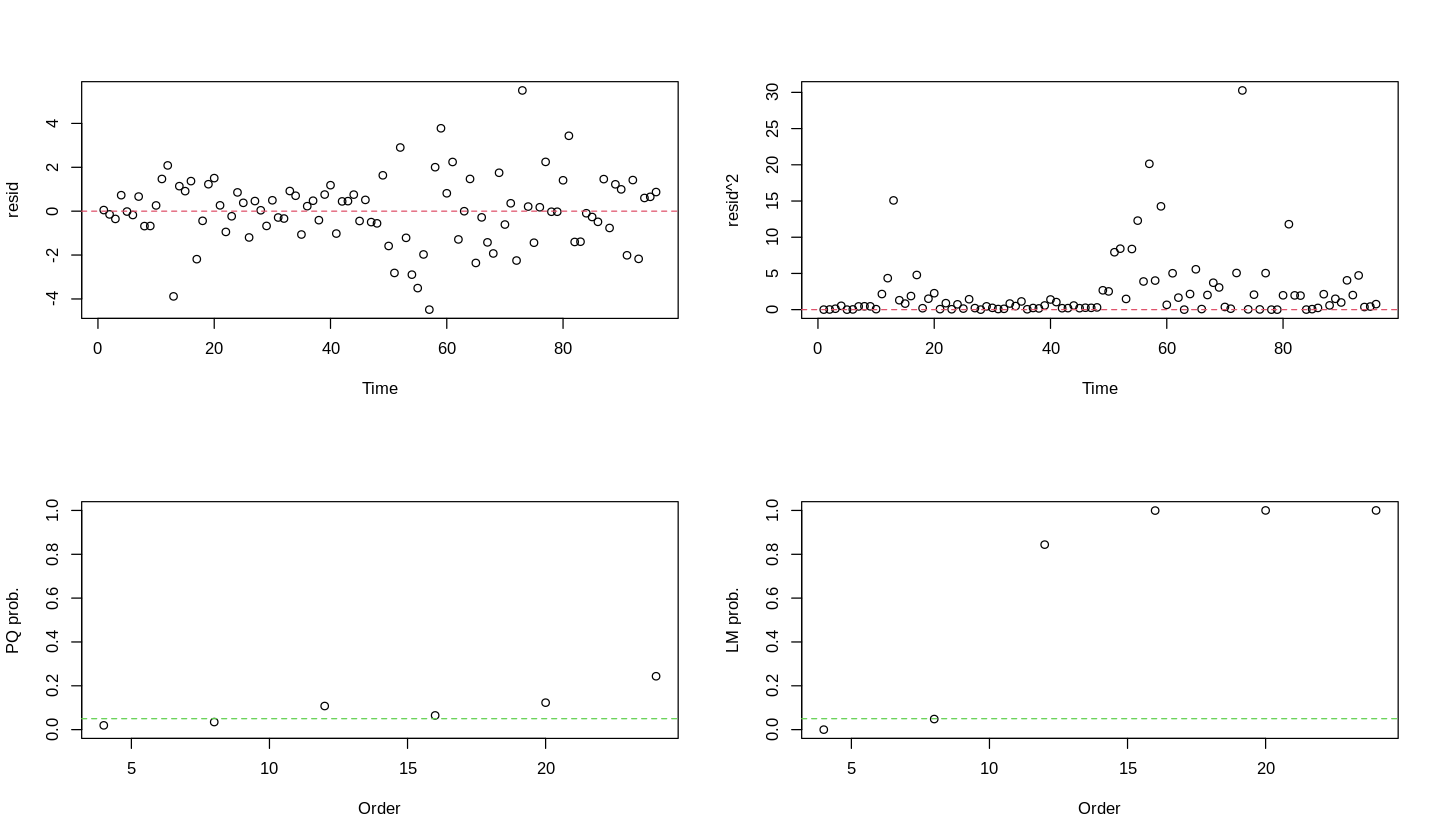

In [ ]:
#Debemos crear un objeto arima(), ya que la función arch.test() no funciona con objetos auto.arima()
Modelo_ARIMA_para_test_ARCH <- arima(Serie_PIB_SI_ajustados_hasta_2018,
                                     order=c(1,2,0), #Nuestro ARIMA era un (1,2,0)
                                     seasonal=c(0,0,0),
                                     include.mean=FALSE) #Nuestro ARIMA no tenía intercepto significativo
#Sobre el anterior objeto arima(), realizamos el test:                                     
Test <- arch.test(Modelo_ARIMA_para_test_ARCH)

Una vez revisados estos gráficos, parece que nuestros residuos son homocedásticos.

De todas formas, empleamos, de nuevo, el test de los multiplicadores de Lagrange, para volver a comprobar el resultado, atendiendo solo a un p-valor:

In [ ]:
ArchTest(ARIMA_Serie_PIB_SI_ajustado$residuals)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  ARIMA_Serie_PIB_SI_ajustado$residuals
Chi-squared = 13.028, df = 12, p-value = 0.367


En este caso, el $p-valor = 0,367$, por lo que no podemos rechazar la hipótesis nula: no existen efectos ARCH, nuestros residuos son homocedásticos.

Por lo tanto, parece que la cuestión sobre si la varianza residual es constante o no, ha quedado inconclusa.

* A continuación, pasamos a estudiar la **independencia de los residuos**:

In [ ]:
#Test de Ljung-Box:
Box.test(ARIMA_Serie_PIB_SI_ajustado$residuals,
         type="Ljung", #Tipo de test
         lag=30, #Número total de retardos sobre los que realizar el test
         fitdf=1) #Grados de libertad: uno por cada coeficientes del modelo (en nuestro caso: el modelo ARIMA(1,2,0)(0,0,0) tiene 1 coeficiente)
#Test de Box-Pierce:
Box.test(ARIMA_Serie_PIB_SI_ajustado$residuals,
         type="Box-Pierce",
         lag=30,
         fitdf=1)


	Box-Ljung test

data:  ARIMA_Serie_PIB_SI_ajustado$residuals
X-squared = 20.704, df = 29, p-value = 0.8697



	Box-Pierce test

data:  ARIMA_Serie_PIB_SI_ajustado$residuals
X-squared = 16.269, df = 29, p-value = 0.9724


Como en los dos casos, el $p-valor > 0,05$, no podemos rechazar la hipótesis nula de independencia (no correlación) de los residuos.

* Finalmente, observamos si los residuos siguen una **distribución normal**:

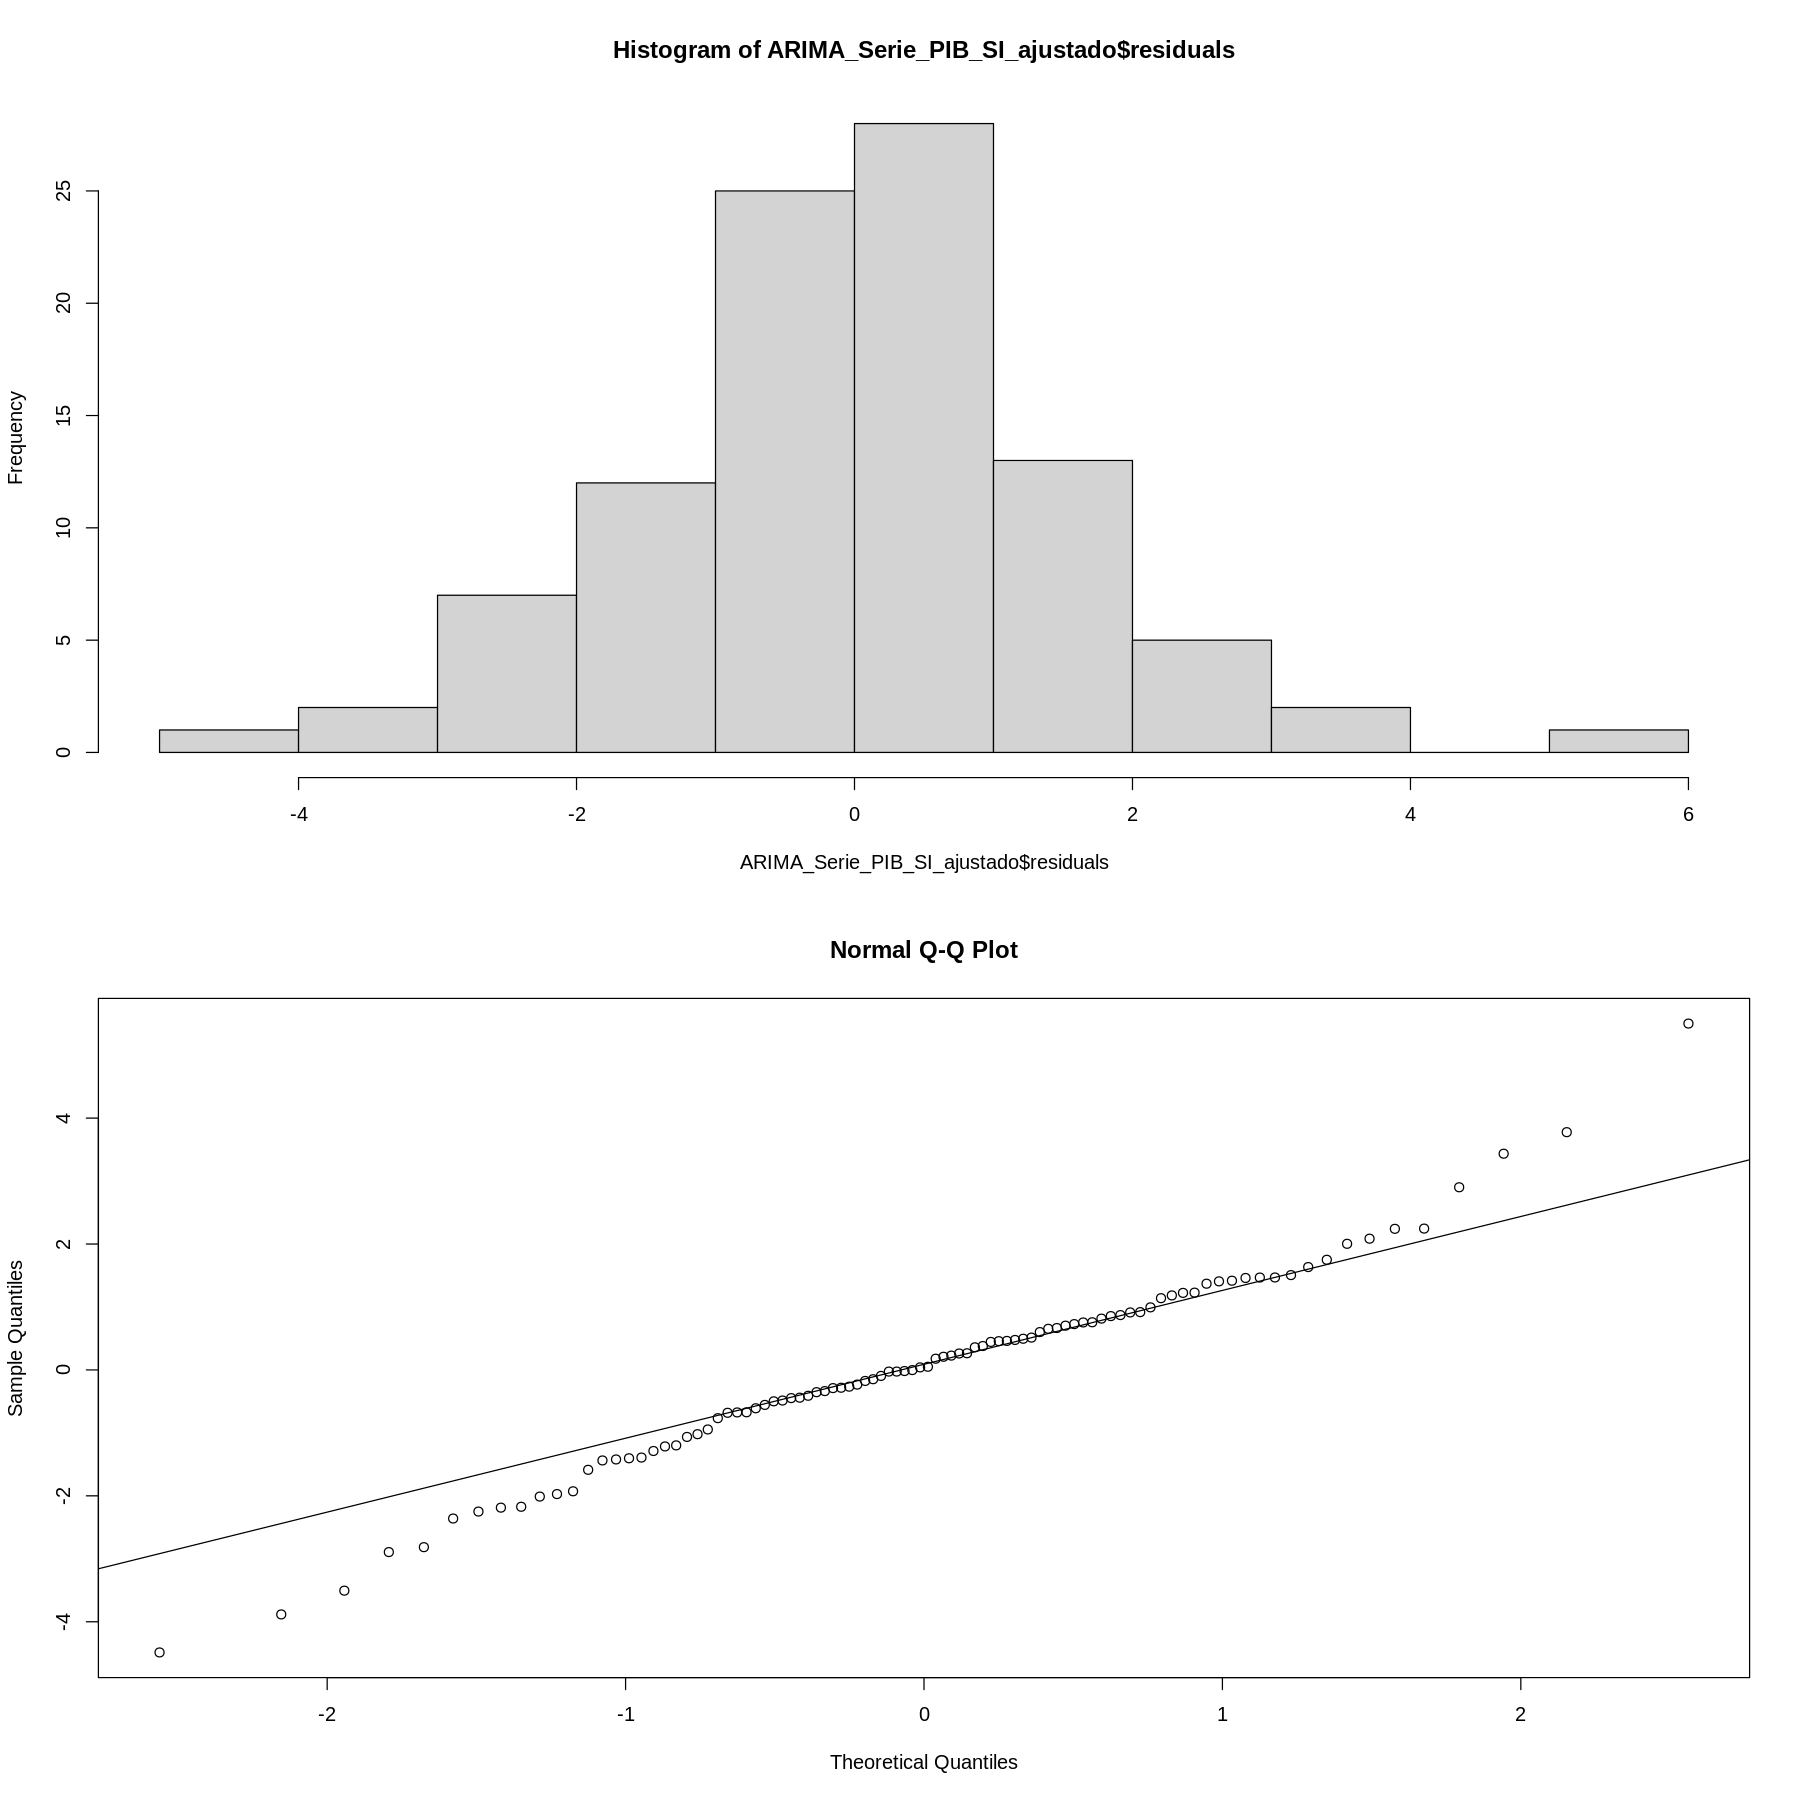

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)
par(mfrow = c(2, 1)) #Para poner los dos gráficos uno debajo del otro
#Histograma de los residuos
hist(ARIMA_Serie_PIB_SI_ajustado$residuals)
#Q-Q plot de los residuos
qqnorm(ARIMA_Serie_PIB_SI_ajustado$residuals)
qqline(ARIMA_Serie_PIB_SI_ajustado$residuals)

In [ ]:
#Test de Shapiro-Wilk:
shapiro.test(ARIMA_Serie_PIB_SI_ajustado$residuals)
#Test de Jarque-Bera:
jarque.bera.test(ARIMA_Serie_PIB_SI_ajustado$residuals)


	Shapiro-Wilk normality test

data:  ARIMA_Serie_PIB_SI_ajustado$residuals
W = 0.97772, p-value = 0.1014



	Jarque Bera Test

data:  ARIMA_Serie_PIB_SI_ajustado$residuals
X-squared = 7.7182, df = 2, p-value = 0.02109


Como ocurría con el estudio de la varianza residual, en este caso, los resultados también son contradictorios: el histograma y el test de Shapiro-Wilk parecen indicar que los residuos se aproximan a la normalidad, mientras que el *Q-Q plot* y el test de Jarque-Bera dicen lo contrario. Entonces, como mucho, podemos decir que los residuos parecen aproximarse a la Normal.

Finalmente, realizamos la predicción de 2019 y su comparación con los datos reales de ese año:

In [ ]:
#Debemos crear un objeto arima(), ya que la función forecast() no funciona con objetos auto.arima()
Modelo_ARIMA_para_predecir <- arima(Serie_PIB_SI_ajustados_hasta_2018,
                                    order=c(1,2,0), #Nuestro ARIMA era un (1,2,0)(0,0,0)
                                    seasonal=c(0,0,0),
                                    include.mean=FALSE) #Nuestro ARIMA no tenía intercepto significativo
#Predecimos el 2019 (4 trimestres) y el intervalo de confianza al 95% de las predicciones:
Prediccion_2019_PIB_SI_ajustado <- forecast(Modelo_ARIMA_para_predecir,
                                            lead=4, #Porque vamos a predecir los 4 siguientes valores
                                            output = F) #Para que no se nos imprima el resultado
#Creamos un dataframe con los resultados de la predicción para facilitar su manejo en R:
Prediccion_2019_PIB_SI_ajustado <- data.frame(Prediccion_2019_PIB_SI_ajustado)
#Nos quedamos solamente con las columnas de valores predichos y del intervalo de confianza:
Prediccion_2019_PIB_SI_ajustado <- Prediccion_2019_PIB_SI_ajustado[,c("Forecast", "Lower", "Upper")]
#Cambiamos el nombre a las columnas:
Prediccion_2019_PIB_SI_ajustado <- rename(Prediccion_2019_PIB_SI_ajustado, Valores_Predichos = Forecast, Confint_Inferior = Lower, Confint_Superior = Upper)

#Convertimos el dataframe en un objeto serie temporal: 
Prediccion_2019_PIB_SI_ajustado <- ts(Prediccion_2019_PIB_SI_ajustado,
                                      start = c(2019, 1), #Fecha de inicio de los datos (primer trimestre de 2019)
                                      frequency = 4) #Periodicidad trimestral (4 trimestres en un año)
Prediccion_2019_PIB_SI_ajustado

,Valores_Predichos,Confint_Inferior,Confint_Superior
2019 Q1,308.8400,305.7259,311.9541
2019 Q2,312.2968,306.7385,317.8552
2019 Q3,315.5858,306.6935,324.4782
2019 Q4,318.9623,306.4262,331.4985


Graficamos la serie real, la predicción y su intervalo de confianza:

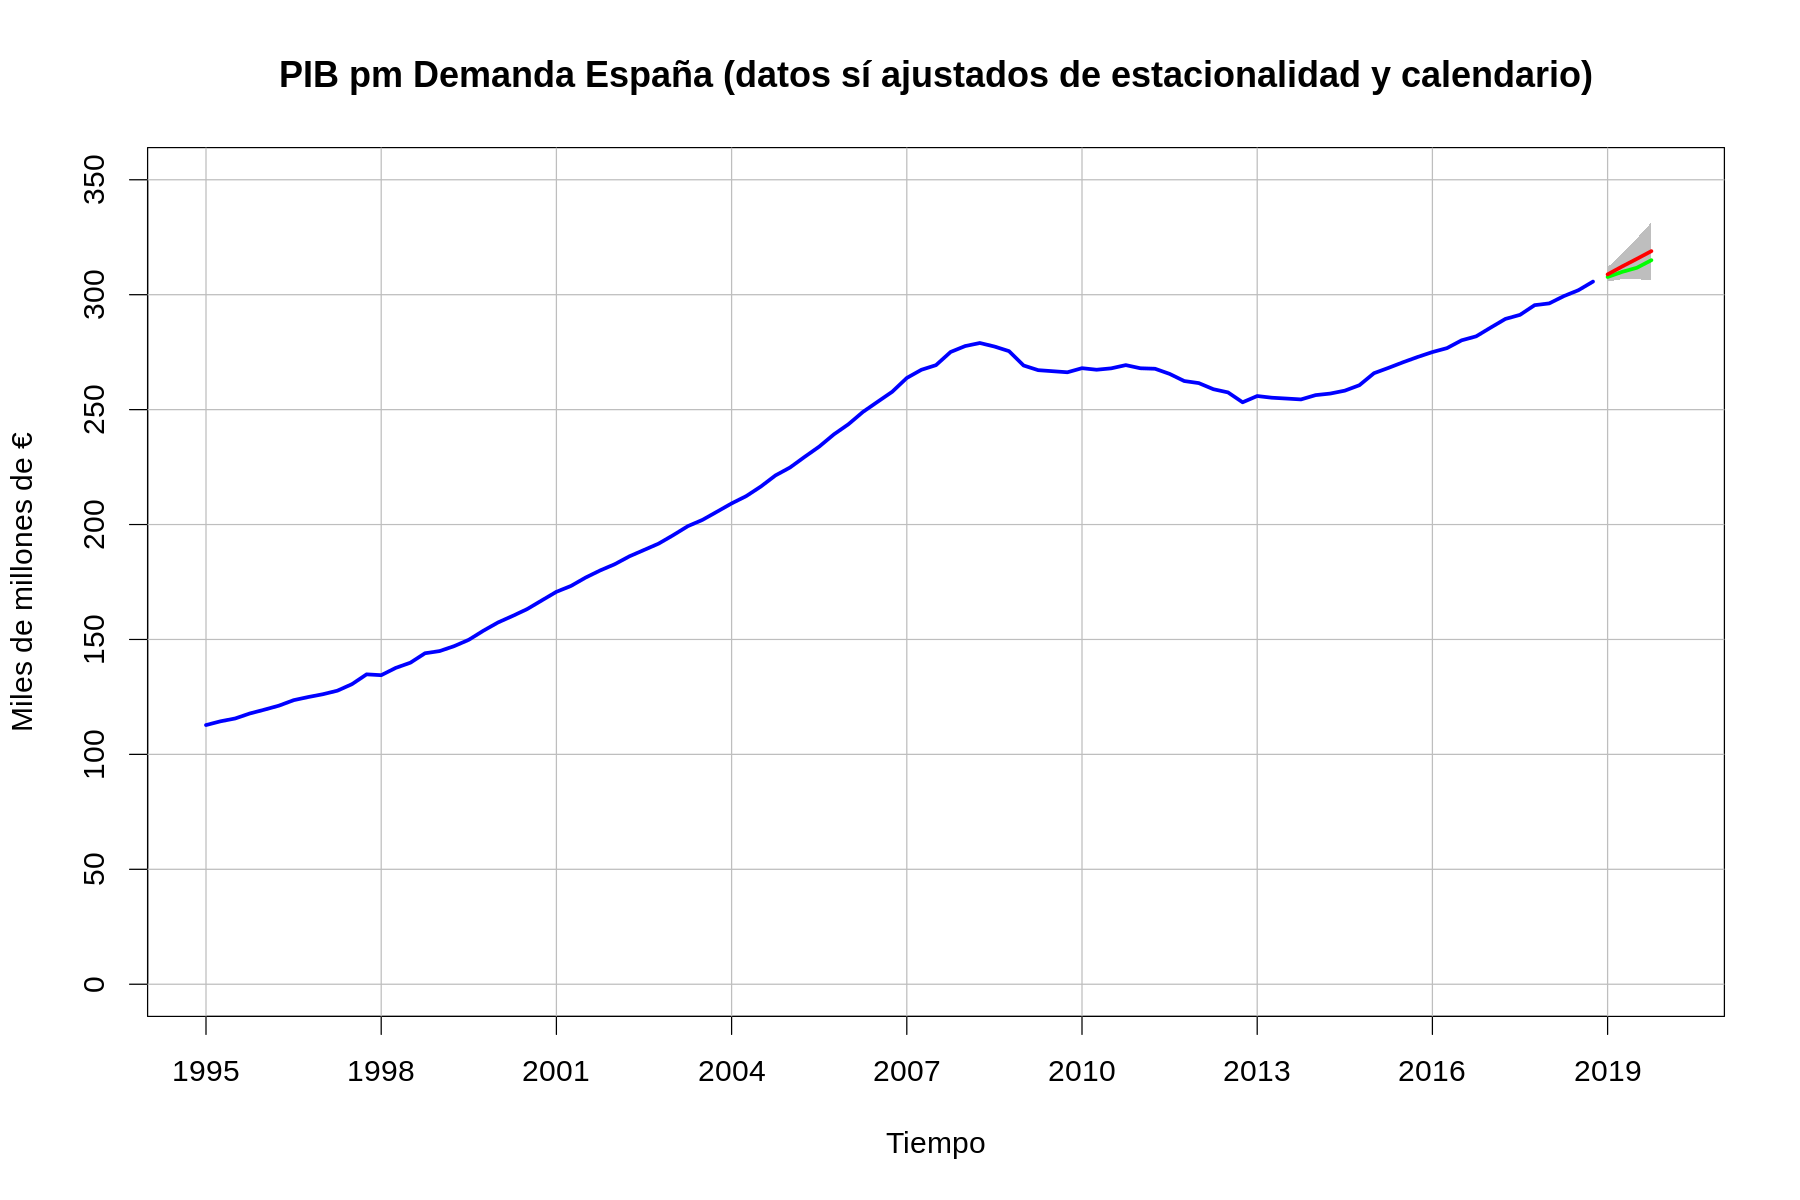

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=10)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Miles de millones de €", 
     main="PIB pm Demanda España (datos sí ajustados de estacionalidad y calendario)", #Título del gráfico
     xlim = c(1995, 2020),
     ylim = c(0, 350),
     xaxp = c(1995, 2019, 8)) #Etiquetas del eje X: de 1995 a 2019 en 8 saltos

#Añadimos una rejilla:
abline(h = c(0, 50, 100, 150, 200, 250, 300, 350), #Líneas horizontales de la rejilla
       v = c(1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016, 2019), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos la serie temporal hasta 2018:
lines(Serie_PIB_SI_ajustados_hasta_2018,
      col="blue", #Color azul
      lwd=3) #Anchura de la línea

#Graficamos el intervalo de confianza de las predicciones (debemos usar la función polygon()):
tiempo <- seq(from=2019, by=1/4, length=4)
polygon(x=c(tiempo, rev(tiempo)),
        y=c(Prediccion_2019_PIB_SI_ajustado[, "Confint_Superior"], rev(Prediccion_2019_PIB_SI_ajustado[, "Confint_Inferior"])),
        col="grey", border=NA)

#Graficamos la serie de 2019:
lines(Serie_PIB_SI_ajustados_2019,
      col="green", lwd=3)

#Graficamos las predicción
lines(Prediccion_2019_PIB_SI_ajustado[, "Valores_Predichos"],
      col="red", lwd=3)

#Es importante seguir este orden: 1) figura vacía, 2) rejilla y 3) serie temporal, para evitar que las líneas de rejilla aparezcan por encima de la serie temporal

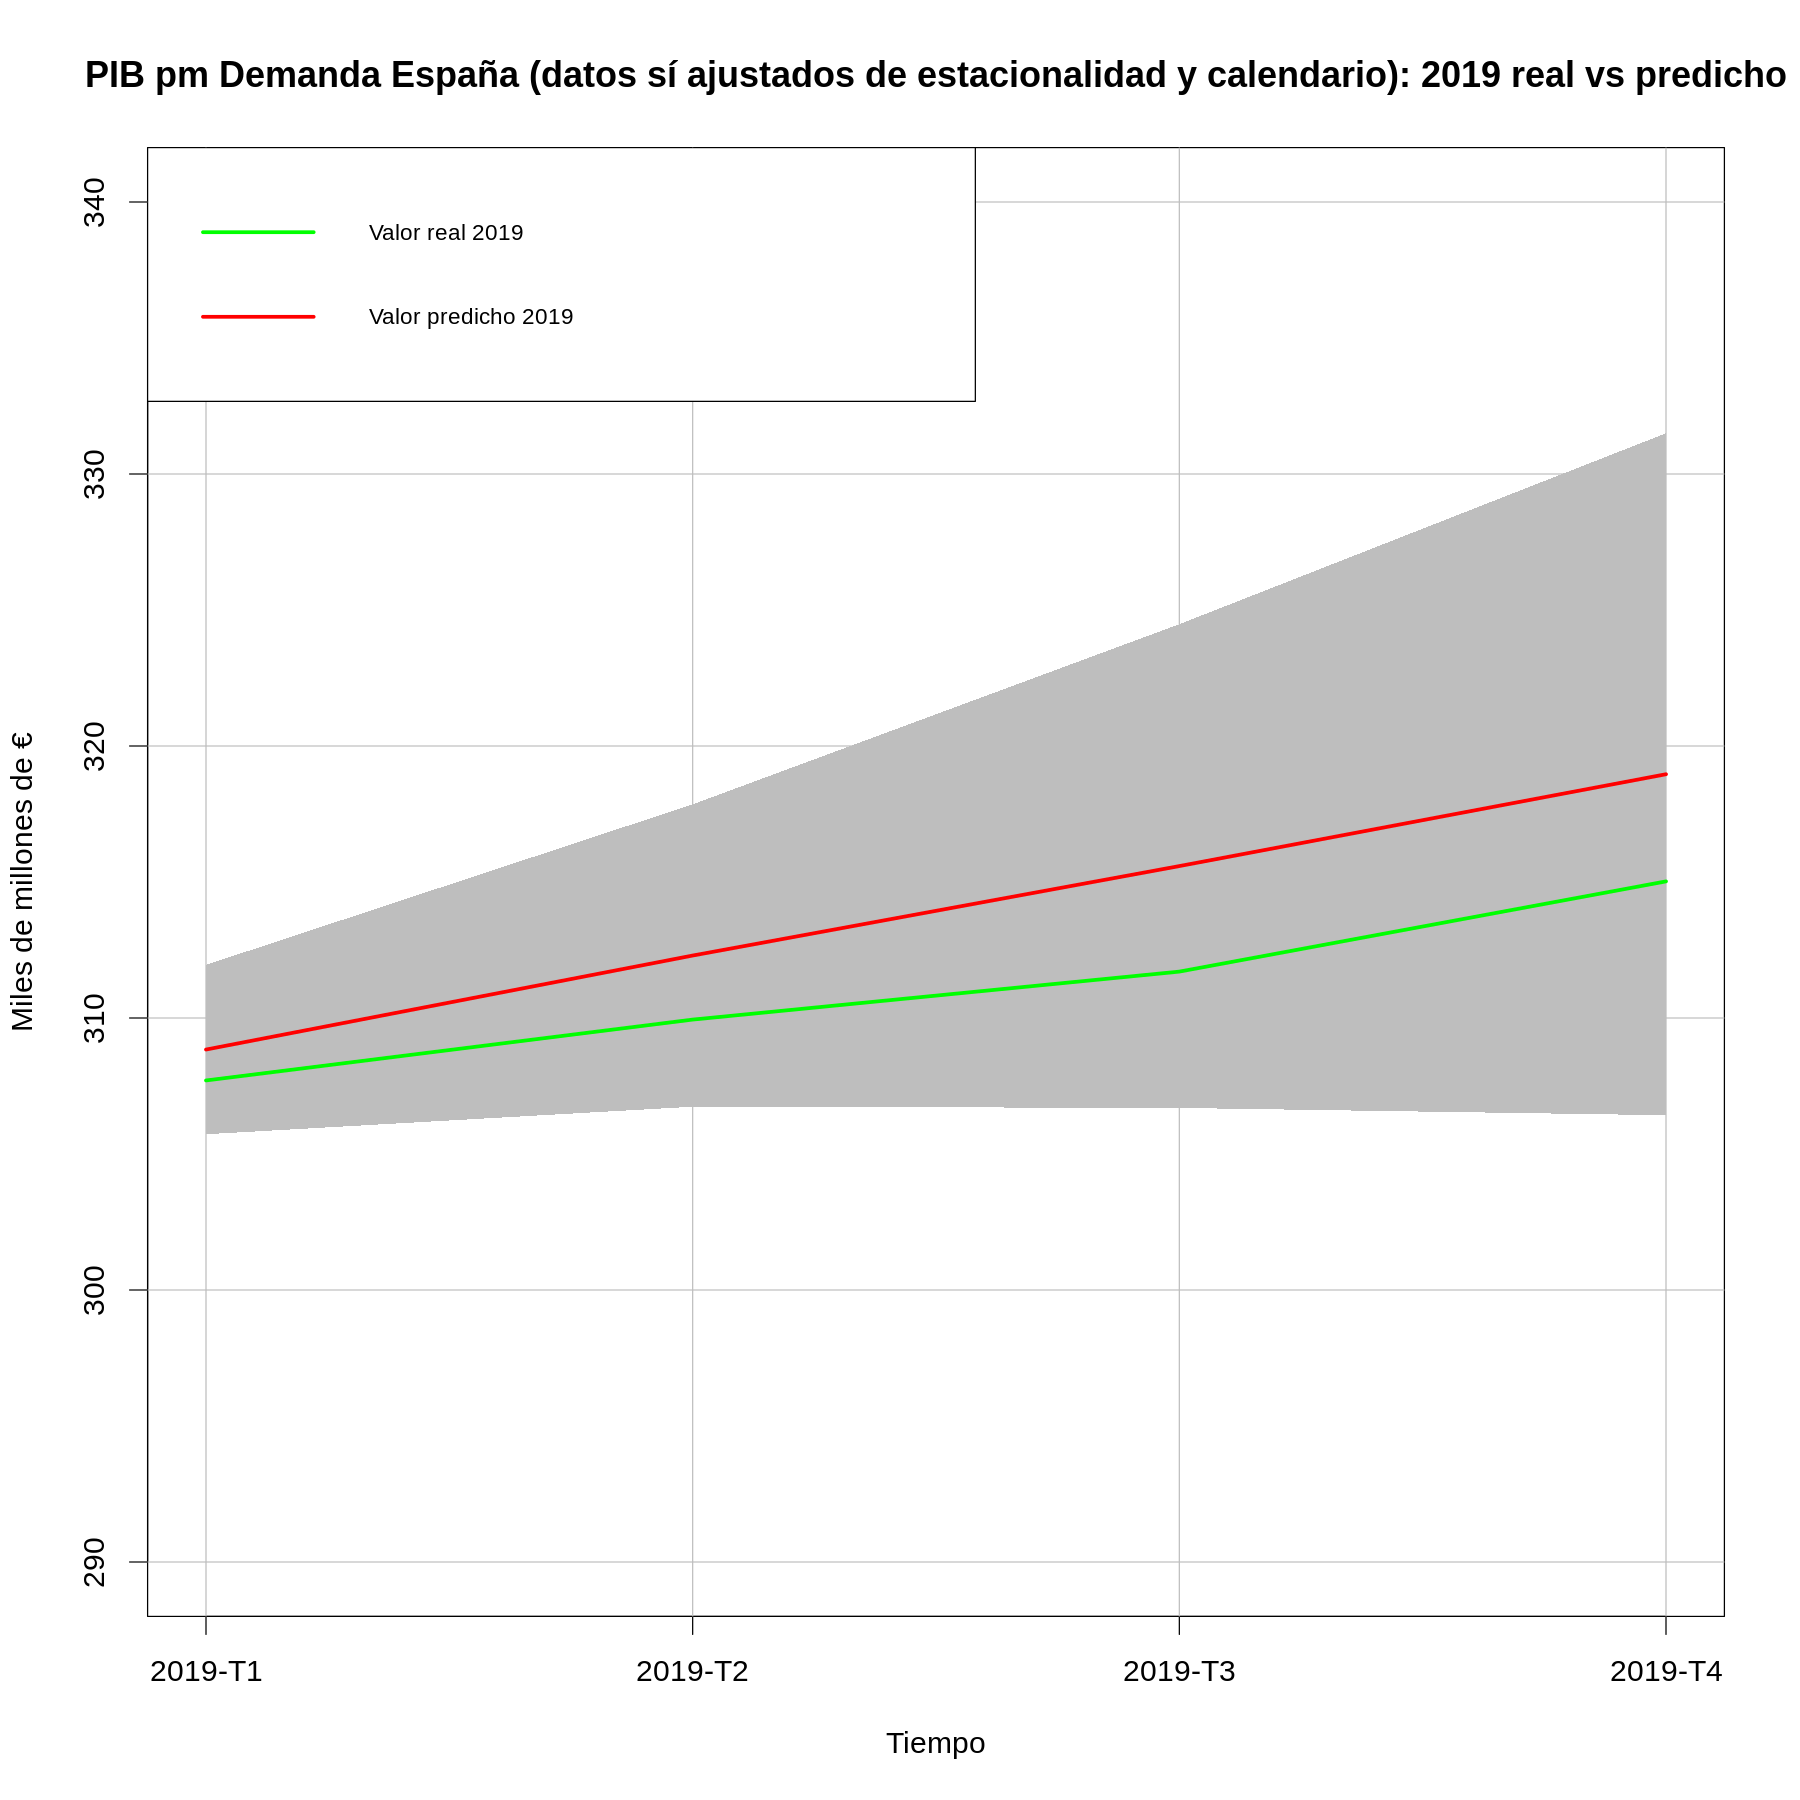

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=15)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Miles de millones de €", 
     main="PIB pm Demanda España (datos sí ajustados de estacionalidad y calendario): 2019 real vs predicho",
     xlim = c(2019, 2019.75),
     ylim = c(290, 340),
     xaxt="n") #Para que el plot() no produzca ticks en el eje X

#Modificamos el eje X (eje 1) para establecer los ticks y las etiquetas donde queramos:
axis(1, at=c(2019, 2019.25, 2019.5, 2019.75), labels=c("2019-T1", "2019-T2", "2019-T3", "2019-T4"))

#Añadimos una rejilla:
abline(h = c(290, 300, 310, 320, 330, 340), #Líneas horizontales de la rejilla
       v = c(2019, 2019.25, 2019.5, 2019.75), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos el intervalo de confianza de las predicciones (debemos usar la función polygon()):
tiempo <- seq(from=2019, by=1/4, length=4)
polygon(x=c(tiempo, rev(tiempo)),
        y=c(Prediccion_2019_PIB_SI_ajustado[, "Confint_Superior"], rev(Prediccion_2019_PIB_SI_ajustado[, "Confint_Inferior"])),
        col="grey", border=NA)

#Graficamos la serie de 2019:
lines(Serie_PIB_SI_ajustados_2019,
      col="green", lwd=3)

#Graficamos las predicciones
lines(Prediccion_2019_PIB_SI_ajustado[, "Valores_Predichos"],
      col="red", lwd=3)

#Añadimos la leyenda
legend(x = "topleft",
       legend=c("Valor real 2019", "Valor predicho 2019"),
       lty=c(1, 1),
       col=c("green", "red"),
       lwd=3,
       cex=0.75)

Como ocurría con los datos no ajustados, los valores predichos son superiores a los reales.

####**Serie temporal IPC Tecnología**

Y repetimos, de nuevo, el proceso con los datos del IPC:

In [ ]:
#Datos hasta 2018 incluido (hasta la fila 228):
entrenamiento_datos_IPC_Tecnologia_hasta_2020 <- datos_IPC_Tecnologia[1:228,]
#Datos de 2019 (a partir de la fila 229):
test_datos_IPC_Tecnologia_2021 = datos_IPC_Tecnologia[229:240,]

In [ ]:
#Nos quedamos solo con la columna IPC_Tecnologia:
Serie_IPC_Tecnologia_hasta_2020 <- entrenamiento_datos_IPC_Tecnologia_hasta_2020[ ,c("IPC_Tecnologia")]
#Convertimos el dataframe en un objeto serie temporal: 
Serie_IPC_Tecnologia_hasta_2020 <- ts(Serie_IPC_Tecnologia_hasta_2020,
                                      start = c(2002, 1), #Fecha de inicio de los datos (enero de 2002)
                                      frequency = 12) #Periodicidad mensual
Serie_IPC_Tecnologia_hasta_2020

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2002,493.091,490.112,487.236,484.317,477.891,477.454,469.111,467.829,465.584,460.186,457.823,454.605
2003,448.812,445.723,443.330,440.590,436.151,430.562,422.590,420.838,417.666,414.883,411.146,409.839
2004,405.289,403.910,400.507,396.484,393.765,391.639,385.808,385.630,382.580,379.317,376.815,373.208
2005,369.350,366.775,364.195,360.922,358.139,353.665,350.644,350.268,348.012,346.225,344.539,343.142
2006,340.432,339.797,336.973,333.017,331.453,328.261,322.717,320.718,317.424,316.556,315.277,312.602
2007,308.597,305.522,301.574,296.806,293.229,289.635,282.561,280.163,277.301,275.062,271.553,268.975
2008,264.256,262.122,259.684,256.891,252.724,248.683,244.267,242.491,240.692,238.067,235.373,233.314
2009,228.849,227.332,225.333,223.484,222.583,221.537,218.129,216.624,215.573,215.139,213.683,212.445
2010,209.941,209.170,208.635,207.830,207.249,206.443,204.692,204.080,203.427,202.463,201.349,198.877
2011,195.273,194.244,191.998,189.884,185.854,184.535,182.316,182.387,180.782,179.388,178.536,177.417


In [ ]:
#Nos quedamos solo con la columna IPC_Tecnologia:
Serie_IPC_Tecnologia_2021 <- test_datos_IPC_Tecnologia_2021[ ,c("IPC_Tecnologia")]
#Convertimos el dataframe en un objeto serie temporal: 
Serie_IPC_Tecnologia_2021 <- ts(Serie_IPC_Tecnologia_2021,
                                start = c(2021, 1), #Fecha de inicio de los datos (enero de 2021)
                                frequency = 12) #Periodicidad mensual
Serie_IPC_Tecnologia_2021

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2021,100.228,100.728,99.867,99.560,99.823,99.552,99.085,99.287,100.252,100.657,100.552,100.409


Graficamos la serie temporal:

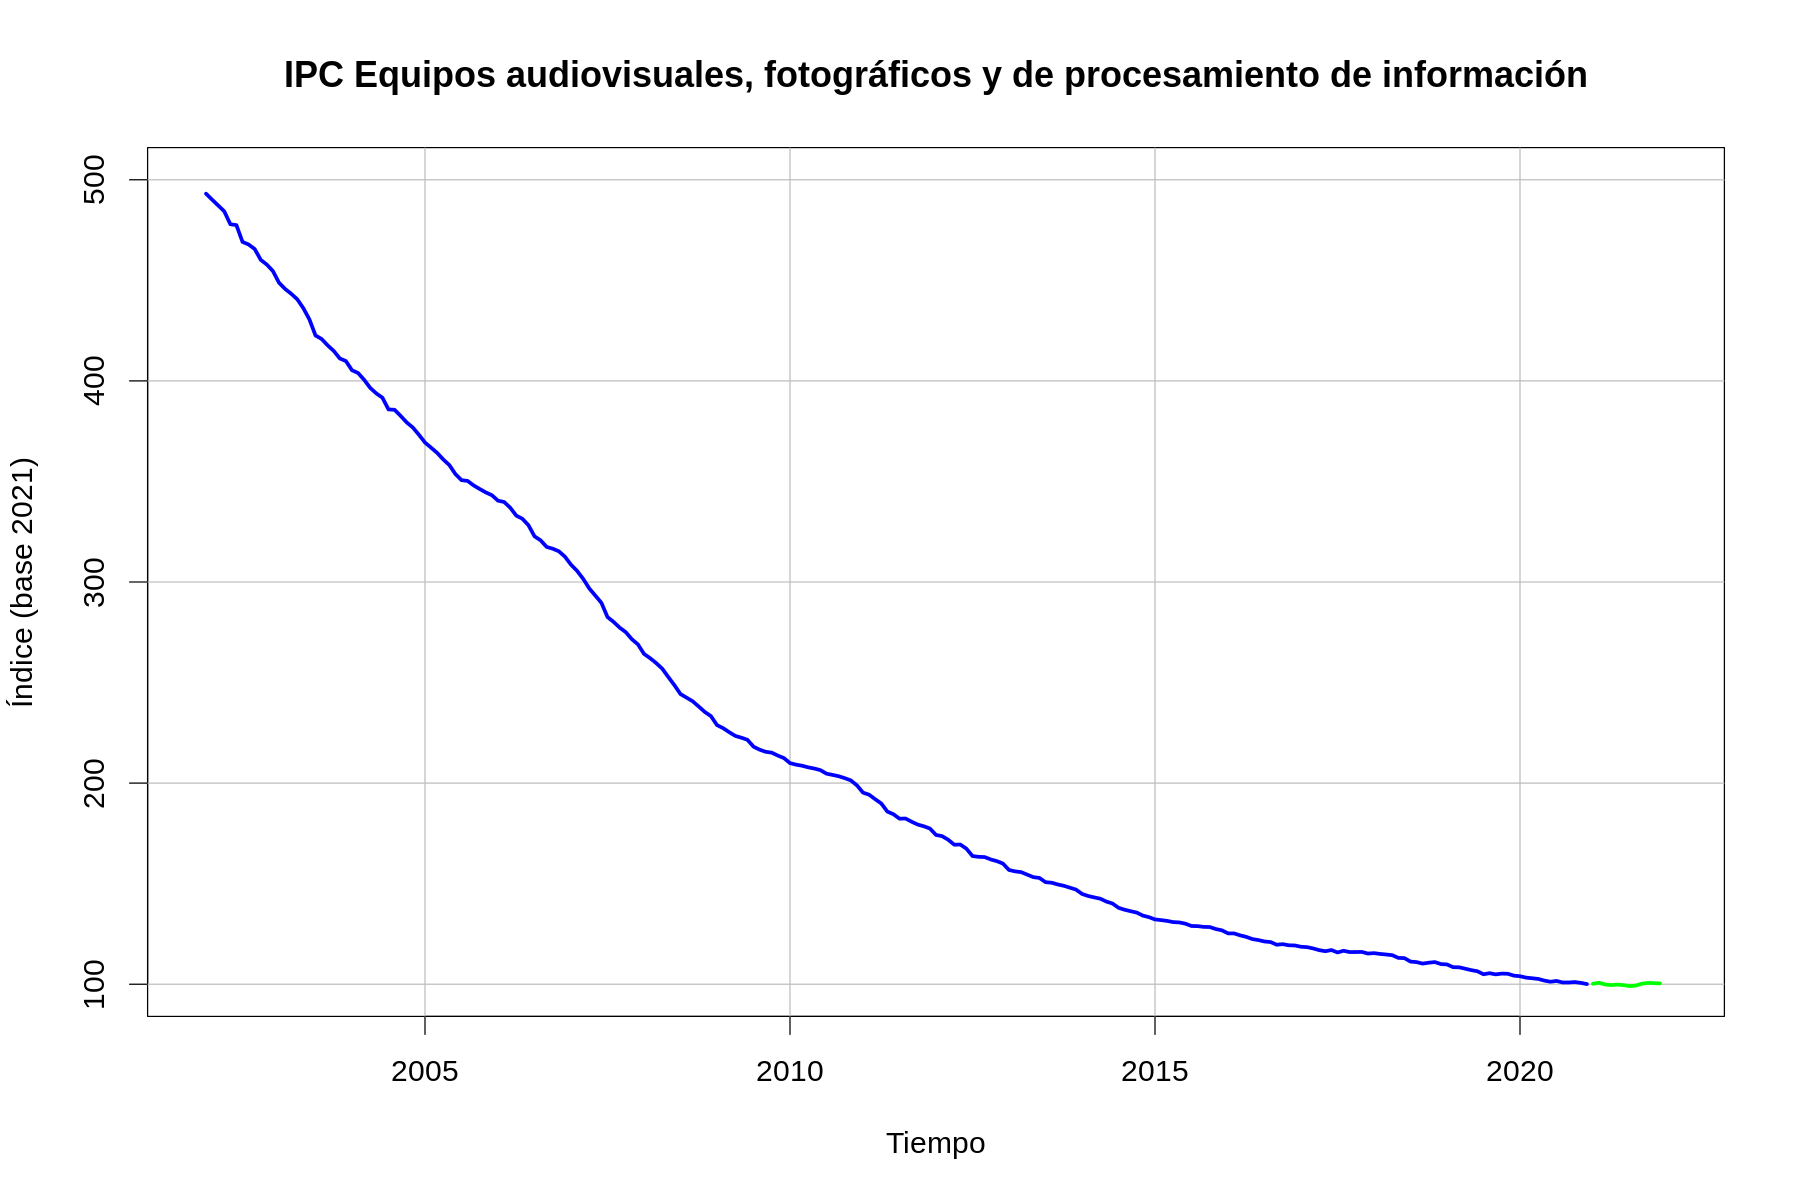

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=10)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Índice (base 2021)", 
     main="IPC Equipos audiovisuales, fotográficos y de procesamiento de información", #Título del gráfico
     xlim = c(2002, 2022),
     ylim = c(100, 500))

#Añadimos una rejilla:
abline(h = c(100, 200, 300, 400, 500), #Líneas horizontales de la rejilla
       v = c(2005, 2010, 2015, 2020), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos la serie temporal hasta 2018:
lines(Serie_IPC_Tecnologia_hasta_2020,
      col="blue", #Color azul
      lwd=3) #Anchura de la línea

#Graficamos la serie de 2019:
lines(Serie_IPC_Tecnologia_2021,
      col="green", lwd=3)

Empleamos `auto.arima()`: como la serie no muestra claramente la presencia de estacionalidad, vamos a probar a usar `auto.arima()` tanto con estacionalidad como sin ella, quedándonos con el modelo que minimice el AIC:

In [ ]:
ARIMA_Serie_IPC_Tecnologia_con_estacionalidad = auto.arima(Serie_IPC_Tecnologia_hasta_2020,
                                                           trace=TRUE, #Para que nos salgan todos los modelos que prueba internamente
                                                           seasonal=TRUE, 
                                                           ic="aic") #Le indicamos que utilice el AIC de los modelos para decidir cúal es el mejor


 Fitting models using approximations to speed things up...

 ARIMA(2,2,2)(1,0,1)[12]                    : 609.2265
 ARIMA(0,2,0)                               : 880.4378
 ARIMA(1,2,0)(1,0,0)[12]                    : 667.643
 ARIMA(0,2,1)(0,0,1)[12]                    : 687.7637
 ARIMA(2,2,2)(0,0,1)[12]                    : Inf
 ARIMA(2,2,2)(1,0,0)[12]                    : 620.1297
 ARIMA(2,2,2)(2,0,1)[12]                    : 569.8012
 ARIMA(2,2,2)(2,0,0)[12]                    : 568.3966
 ARIMA(1,2,2)(2,0,0)[12]                    : 564.7877
 ARIMA(1,2,2)(1,0,0)[12]                    : 619.5562
 ARIMA(1,2,2)(2,0,1)[12]                    : 564.9246
 ARIMA(1,2,2)(1,0,1)[12]                    : 605.76
 ARIMA(0,2,2)(2,0,0)[12]                    : 570.2877
 ARIMA(1,2,1)(2,0,0)[12]                    : 564.0604
 ARIMA(1,2,1)(1,0,0)[12]                    : 619.4872
 ARIMA(1,2,1)(2,0,1)[12]                    : 565.2056
 ARIMA(1,2,1)(1,0,1)[12]                    : 606.4882
 ARIMA(0,2,1

In [ ]:
ARIMA_Serie_IPC_Tecnologia_sin_estacionalidad = auto.arima(Serie_IPC_Tecnologia_hasta_2020,
                                                           trace=TRUE, #Para que nos salgan todos los modelos que prueba internamente
                                                           seasonal= FALSE,
                                                           ic="aic") #Le indicamos que utilice el AIC de los modelos para decidir cúal es el mejor


 Fitting models using approximations to speed things up...

 ARIMA(2,2,2)                               : 715.7272
 ARIMA(0,2,0)                               : 880.4378
 ARIMA(1,2,0)                               : 780.96
 ARIMA(0,2,1)                               : 715.8861
 ARIMA(1,2,2)                               : 712.8726
 ARIMA(0,2,2)                               : 709.9985
 ARIMA(0,2,3)                               : 711.0797
 ARIMA(1,2,1)                               : 710.8751
 ARIMA(1,2,3)                               : 714.5994

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,2,2)                               : 712.4687

 Best model: ARIMA(0,2,2)                               



In [ ]:
cat("Como el AIC del modelo con estacionalidad (", ARIMA_Serie_IPC_Tecnologia_con_estacionalidad$aic, ") es menor que el que no tiene estacionalidad (", ARIMA_Serie_IPC_Tecnologia_sin_estacionalidad$aic, "), nos quedamos con el primero.")

Como el AIC del modelo con estacionalidad ( 647.1506 ) es menor que el que no tiene estacionalidad ( 712.4687 ), nos quedamos con el primero.

In [ ]:
#Abreviamos el nombre del modelo seleccionado:
ARIMA_Serie_IPC_Tecnologia <- ARIMA_Serie_IPC_Tecnologia_con_estacionalidad

In [ ]:
#Coeficientes estimados del modelo:
ARIMA_Serie_IPC_Tecnologia

Series: Serie_IPC_Tecnologia_hasta_2020 
ARIMA(1,2,1)(2,0,0)[12] 

Coefficients:
          ar1      ma1    sar1    sar2
      -0.1463  -0.7681  0.3513  0.3265
s.e.   0.0819   0.0556  0.0665  0.0731

sigma^2 = 0.9684:  log likelihood = -318.58
AIC=647.15   AICc=647.42   BIC=664.25

In [ ]:
#¿Son los coeficientes estadísticamente significativos?
coeftest(ARIMA_Serie_IPC_Tecnologia)


z test of coefficients:

      Estimate Std. Error  z value  Pr(>|z|)    
ar1  -0.146329   0.081906  -1.7865   0.07401 .  
ma1  -0.768071   0.055641 -13.8040 < 2.2e-16 ***
sar1  0.351336   0.066491   5.2840 1.264e-07 ***
sar2  0.326484   0.073071   4.4680 7.895e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Según `auto.arima()` el modelo que mejor ajusta a los datos es un $ARIMA(1,2,1)(2,0,0)_12$:
\begin{align}
Δ^2Y_t = -0,146329Y_{t-1}+a_t-0,768071a_{t-1}+0,351336Y_{t-12}-0,326484a_{t-24}
\end{align}
Si atendemos a los $p-valores$ de los coeficientes, podemos considerar que todos son estadísticamente significativos, al menos, al nivel de significación $\alpha=0,1$.

Pasamos, entonces, al estudio de los residuos:
* Comprobemos primero si la **media residual** es cero:

In [ ]:
#Media de los residuos:
mean(ARIMA_Serie_IPC_Tecnologia$residuals)

[1] 0.01447557

In [ ]:
#Test de la t para comprobar si la media residual es estadísticamente distinta de cero:
t.test(ARIMA_Serie_IPC_Tecnologia$residuals)


	One Sample t-test

data:  ARIMA_Serie_IPC_Tecnologia$residuals
t = 0.22463, df = 227, p-value = 0.8225
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.1125052  0.1414564
sample estimates:
 mean of x 
0.01447557 


Como el $p-valor = 0,8225$ es mayor que los niveles de significación habituales (0,01; 0,05; y 0,1), no podemos rechazar la hipótesis nula de que la media de los residuos es igual a cero.

* Seguimos con el estudio de la **varianza residual**:

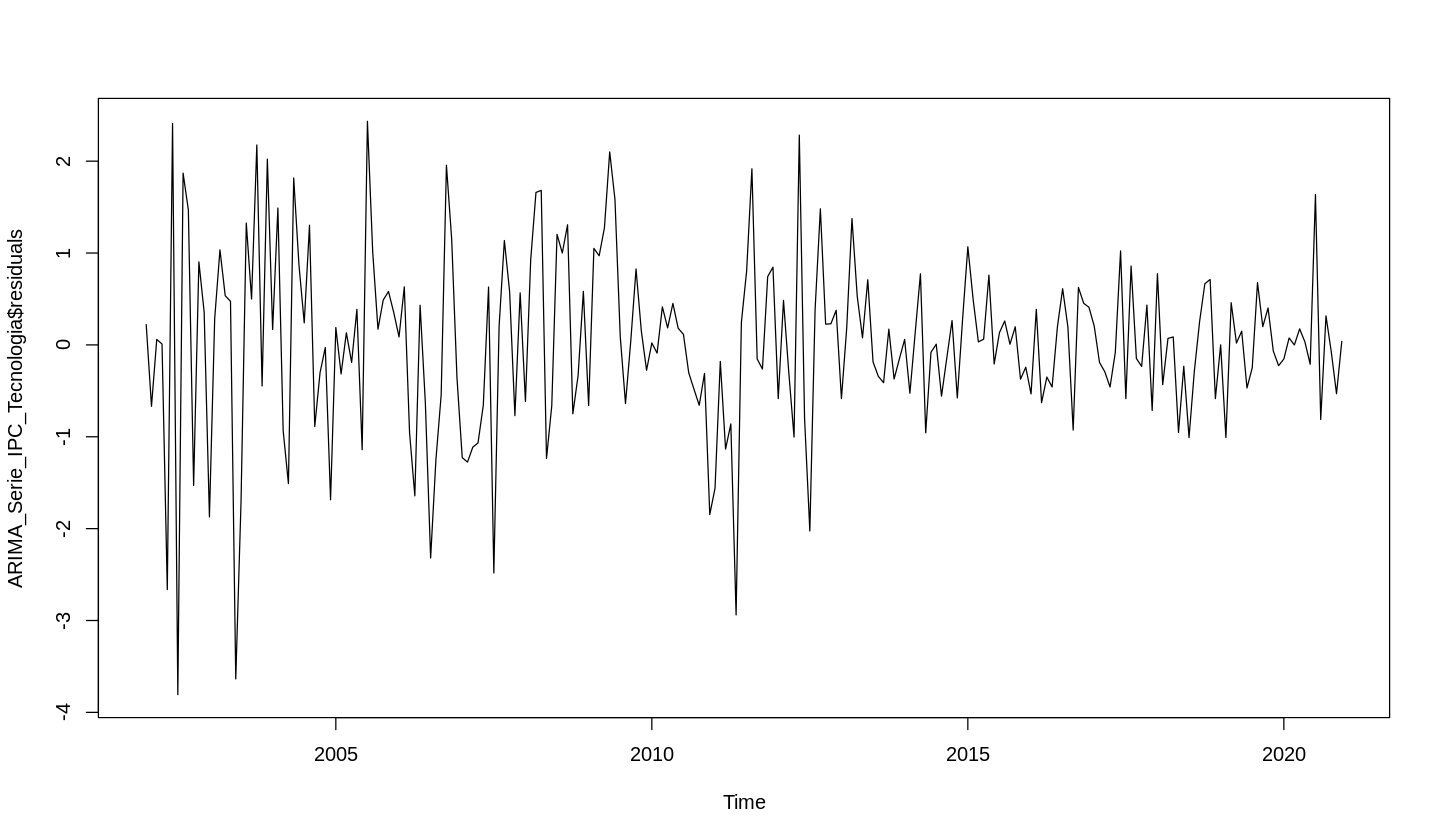

In [ ]:
options(repr.plot.width=12, repr.plot.height=7)
plot(ARIMA_Serie_IPC_Tecnologia$residuals)

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order   PQ  p.value
[1,]     4 27.9 1.32e-05
[2,]     8 32.2 8.74e-05
[3,]    12 65.4 2.32e-09
[4,]    16 74.7 1.46e-09
[5,]    20 78.5 7.11e-09
[6,]    24 83.2 1.83e-08
Lagrange-Multiplier test: 
     order     LM  p.value
[1,]     4 102.13 0.00e+00
[2,]     8  45.60 1.05e-07
[3,]    12  19.32 5.56e-02
[4,]    16  12.32 6.54e-01
[5,]    20   9.06 9.73e-01
[6,]    24   7.46 9.99e-01


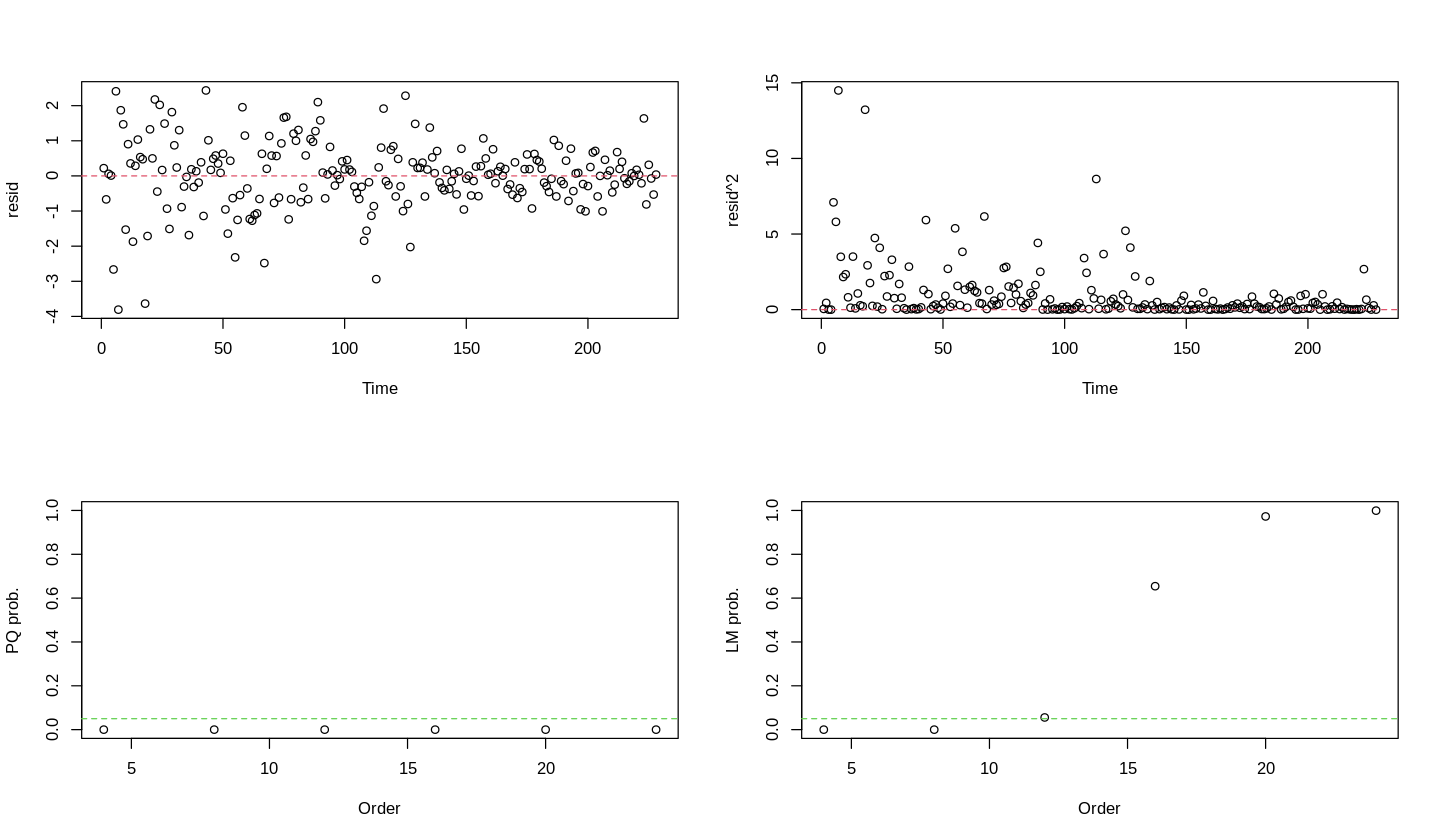

In [ ]:
#Debemos crear un objeto arima(), ya que la función arch.test() no funciona con objetos auto.arima()
Modelo_ARIMA_para_test_ARCH <- arima(Serie_IPC_Tecnologia_hasta_2020,
                                     order=c(1,2,1), #Nuestro ARIMA era un (1,2,1)(2,0,0)
                                     seasonal=c(2,0,0),
                                     include.mean=FALSE) #Nuestro ARIMA no tenía intercepto significativo
#Sobre el anterior objeto arima(), realizamos el test:                                     
Test <- arch.test(Modelo_ARIMA_para_test_ARCH)

In [ ]:
ArchTest(ARIMA_Serie_IPC_Tecnologia$residuals)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  ARIMA_Serie_IPC_Tecnologia$residuals
Chi-squared = 46.252, df = 12, p-value = 6.277e-06


Salvo en el gráfico del `Portmanteau-Q test`, en el resto de casos, tanto gráficos como p-valores muestran que la varianza residual parece reducirse con el tiempo, por lo que no es constante: los residuos son heterocedásticos.

* A continuación, pasamos a estudiar la **independencia de los residuos**:

In [ ]:
#Test de Ljung-Box:
Box.test(ARIMA_Serie_IPC_Tecnologia$residuals,
         type="Ljung", #Tipo de test
         lag=30, #Número total de retardos sobre los que realizar el test
         fitdf=4) #Grados de libertad: uno por cada coeficientes del modelo (en nuestro caso: el modelo ARIMA(1,2,1)(2,0,0) tiene 4 coeficientes: 1+2+1+2+0+0)
#Test de Box-Pierce:
Box.test(ARIMA_Serie_IPC_Tecnologia$residuals,
         type="Box-Pierce",
         lag=30,
         fitdf=4)


	Box-Ljung test

data:  ARIMA_Serie_IPC_Tecnologia$residuals
X-squared = 41.441, df = 26, p-value = 0.028



	Box-Pierce test

data:  ARIMA_Serie_IPC_Tecnologia$residuals
X-squared = 37.797, df = 26, p-value = 0.06324


En ambos casos, los dos tests muestran que los residuos del modelo no son independientes, ya que su $p-valor <0,1$ .

* Finalmente, observamos si los residuos siguen una **distribución normal**:

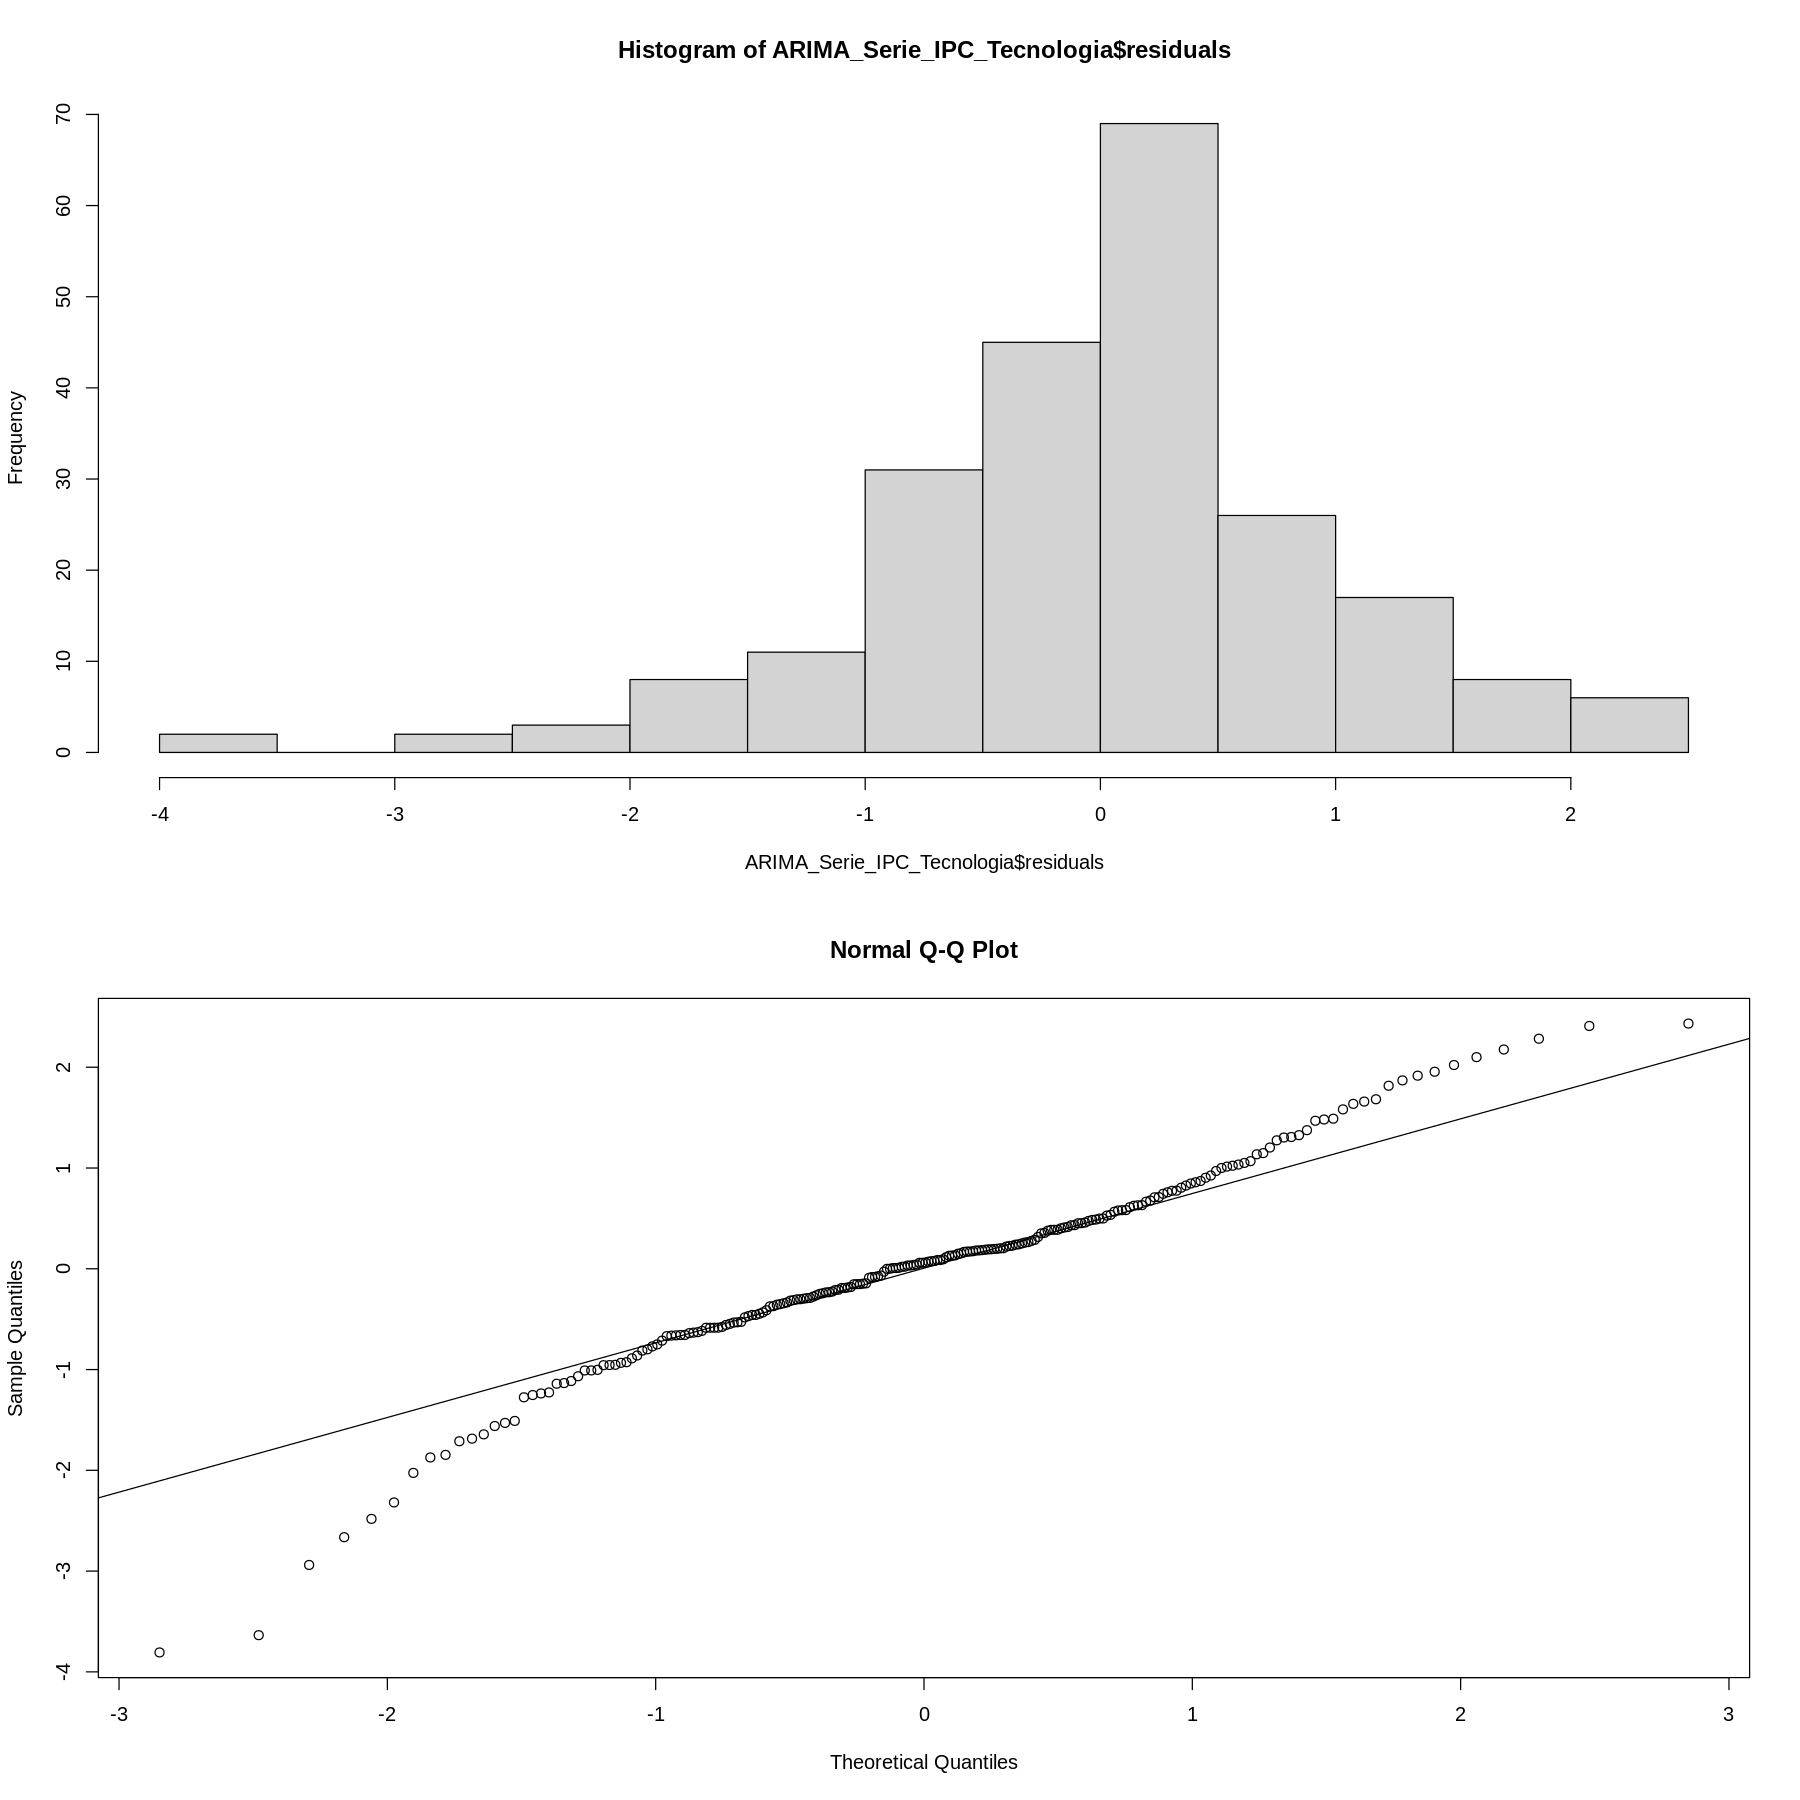

In [ ]:
options(repr.plot.width=15, repr.plot.height=15)
par(mfrow = c(2, 1)) #Para poner los dos gráficos uno debajo del otro
#Histograma de los residuos
hist(ARIMA_Serie_IPC_Tecnologia$residuals)
#Q-Q plot de los residuos
qqnorm(ARIMA_Serie_IPC_Tecnologia$residuals)
qqline(ARIMA_Serie_IPC_Tecnologia$residuals)

In [ ]:
#Test de Shapiro-Wilk:
shapiro.test(ARIMA_Serie_IPC_Tecnologia$residuals)
#Test de Jarque-Bera:
jarque.bera.test(ARIMA_Serie_IPC_Tecnologia$residuals)


	Shapiro-Wilk normality test

data:  ARIMA_Serie_IPC_Tecnologia$residuals
W = 0.96688, p-value = 3.666e-05



	Jarque Bera Test

data:  ARIMA_Serie_IPC_Tecnologia$residuals
X-squared = 40.992, df = 2, p-value = 1.255e-09


Tanto los gráficos como los contrastes muestran que los residuos no se distribuyen como la Normal.

El mal desempeño de los residuos de este modelo, que casi nada tienen que ver con el ruido blanco (especialmente, la falta de independencia residual), es un aviso crucial de que el modelo no es bueno. Aún así, siguiendo la estructura anterior, pasamos a predecir el año 2021 y a compararlo con el 2021 real:

In [ ]:
#Debemos crear un objeto arima(), ya que la función forecast() no funciona con objetos auto.arima()
Modelo_ARIMA_para_predecir <- arima(Serie_IPC_Tecnologia_hasta_2020,
                                    order=c(1,2,1), #Nuestro ARIMA era un (1,2,1)(2,0,0)
                                    seasonal=c(2,0,0),
                                    include.mean=FALSE) #Nuestro ARIMA no tenía intercepto significativo
#Predecimos el 2021 (12 meses) y el intervalo de confianza al 95% de las predicciones:
Prediccion_2021_IPC_Tecnologia <- forecast(Modelo_ARIMA_para_predecir,
                                           lead=12, #Porque vamos a predecir los 12 siguientes valores
                                           output = F) #Para que no se nos imprima el resultado
#Creamos un dataframe con los resultados de la predicción para facilitar su manejo en R:
Prediccion_2021_IPC_Tecnologia <- data.frame(Prediccion_2021_IPC_Tecnologia)
#Nos quedamos solamente con las columnas de valores predichos y del intervalo de confianza:
Prediccion_2021_IPC_Tecnologia <- Prediccion_2021_IPC_Tecnologia[,c("Forecast", "Lower", "Upper")]
#Cambiamos el nombre a las columnas:
Prediccion_2021_IPC_Tecnologia <- rename(Prediccion_2021_IPC_Tecnologia, Valores_Predichos = Forecast, Confint_Inferior = Lower, Confint_Superior = Upper)

#Convertimos el dataframe en un objeto serie temporal: 
Prediccion_2021_IPC_Tecnologia <- ts(Prediccion_2021_IPC_Tecnologia,
                                     start = c(2021, 1), #Fecha de inicio de los datos (primer trimestre de 2019)
                                     frequency = 12) #Periodicidad trimestral (4 trimestres en un año)
Prediccion_2021_IPC_Tecnologia

,Valores_Predichos,Confint_Inferior,Confint_Superior
Jan 2021,99.83256,97.92319,101.7419
Feb 2021,99.08833,96.27013,101.9065
Mar 2021,98.90267,95.14089,102.6644
Apr 2021,98.49839,93.76482,103.2320
May 2021,97.91819,92.17049,103.6659
Jun 2021,97.47885,90.67201,104.2857
Jul 2021,97.07449,89.16269,104.9863
Aug 2021,96.92868,87.86638,105.9910
Sep 2021,96.67897,86.42142,106.9365
Oct 2021,96.81866,85.32207,108.3153


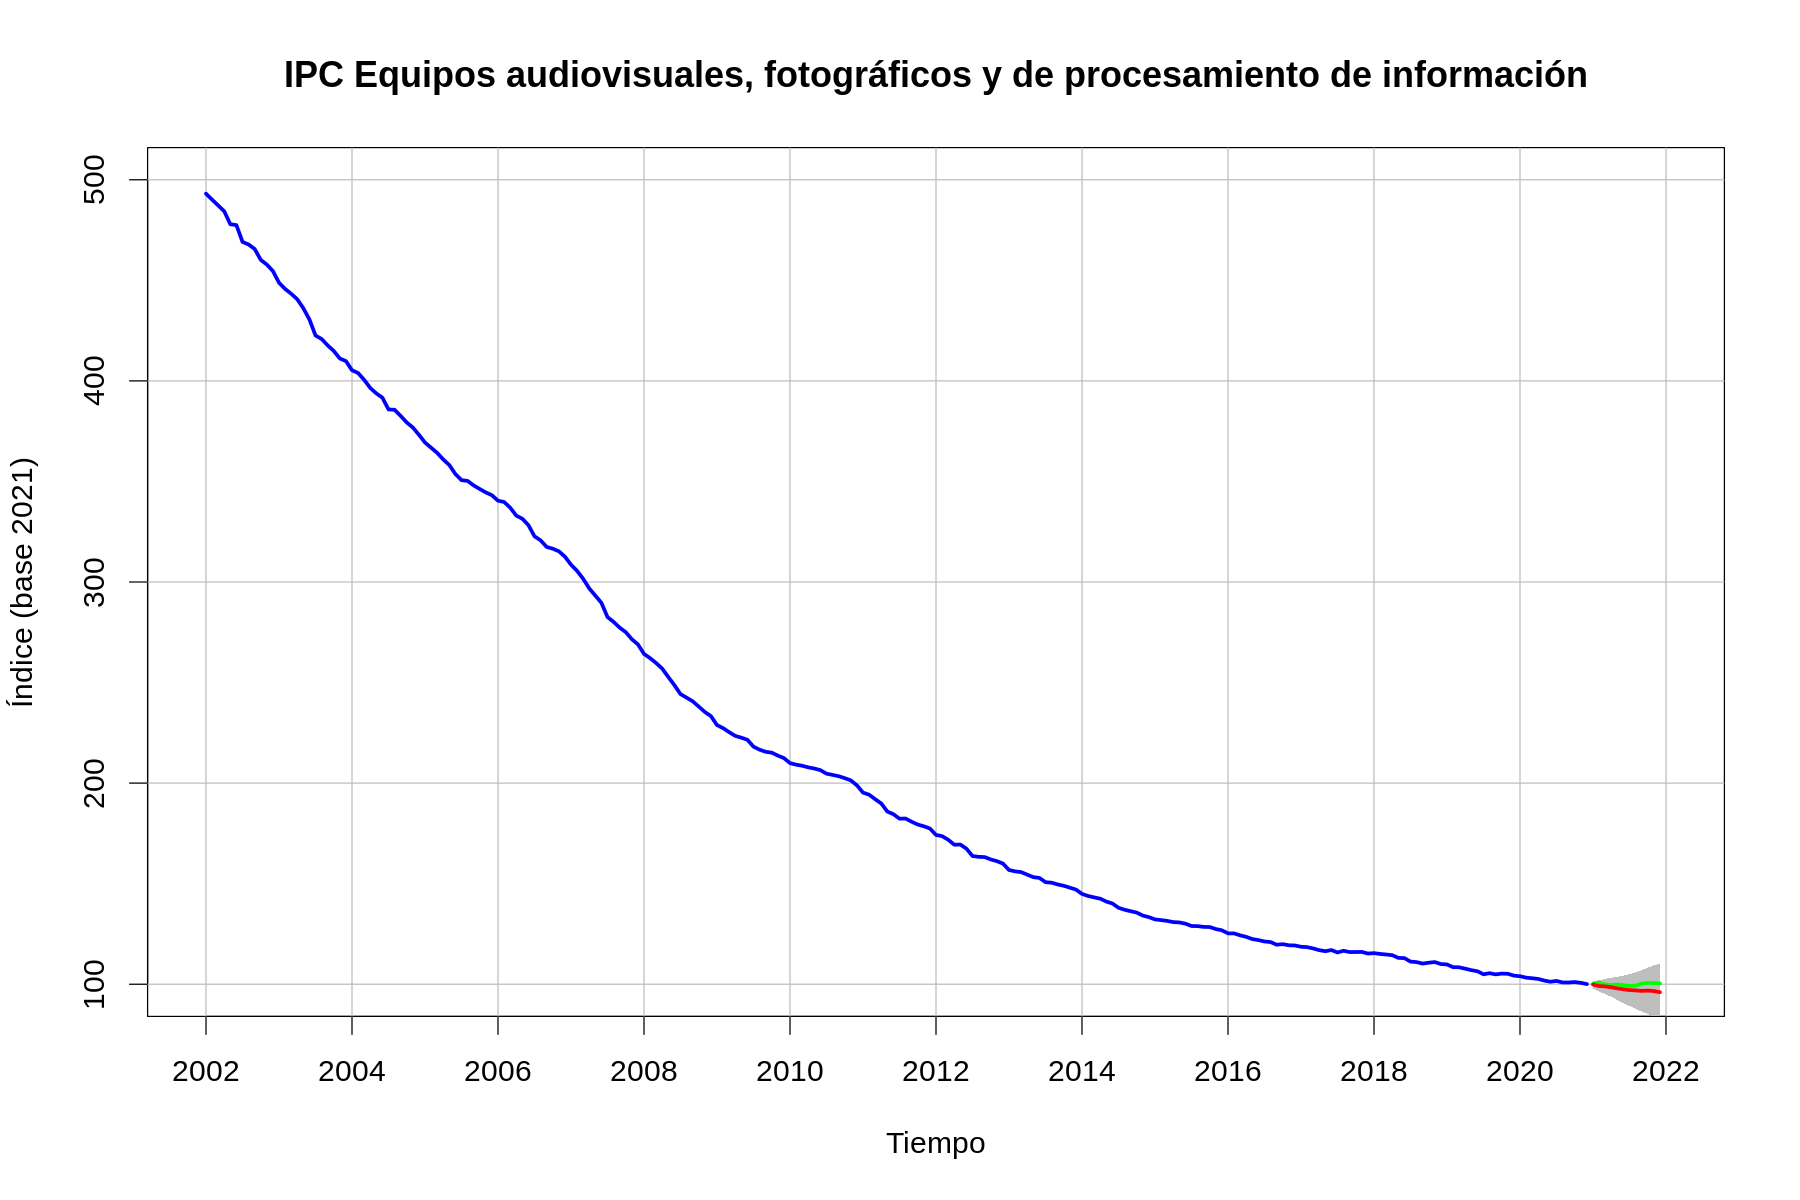

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=10)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Índice (base 2021)", 
     main="IPC Equipos audiovisuales, fotográficos y de procesamiento de información", #Título del gráfico
     xlim = c(2002, 2022),
     ylim = c(100, 500),
     xaxp = c(2002, 2022, 10)) #Etiquetas del eje X: de 2002 a 2020 en 9 saltos

#Añadimos una rejilla:
abline(h = c(100, 200, 300, 400, 500), #Líneas horizontales de la rejilla
       v = c(2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022), #Líneas verticales de la rejilla
       col = "grey") 

#Graficamos la serie temporal hasta 2018:
lines(Serie_IPC_Tecnologia_hasta_2020,
      col="blue", #Color azul
      lwd=3) #Anchura de la línea

#Graficamos el intervalo de confianza de las predicciones (debemos usar la función polygon()):
tiempo <- seq(from=2021, by=1/12, length=12)
polygon(x=c(tiempo, rev(tiempo)),
        y=c(Prediccion_2021_IPC_Tecnologia[, "Confint_Superior"], rev(Prediccion_2021_IPC_Tecnologia[, "Confint_Inferior"])),
        col="grey", border=NA)

#Graficamos la serie de 2019:
lines(Serie_IPC_Tecnologia_2021,
      col="green", lwd=3)

#Graficamos las predicción
lines(Prediccion_2021_IPC_Tecnologia[, "Valores_Predichos"],
      col="red", lwd=3)

#Es importante seguir este orden: 1) figura vacía, 2) rejilla y 3) serie temporal, para evitar que las líneas de rejilla aparezcan por encima de la serie temporal

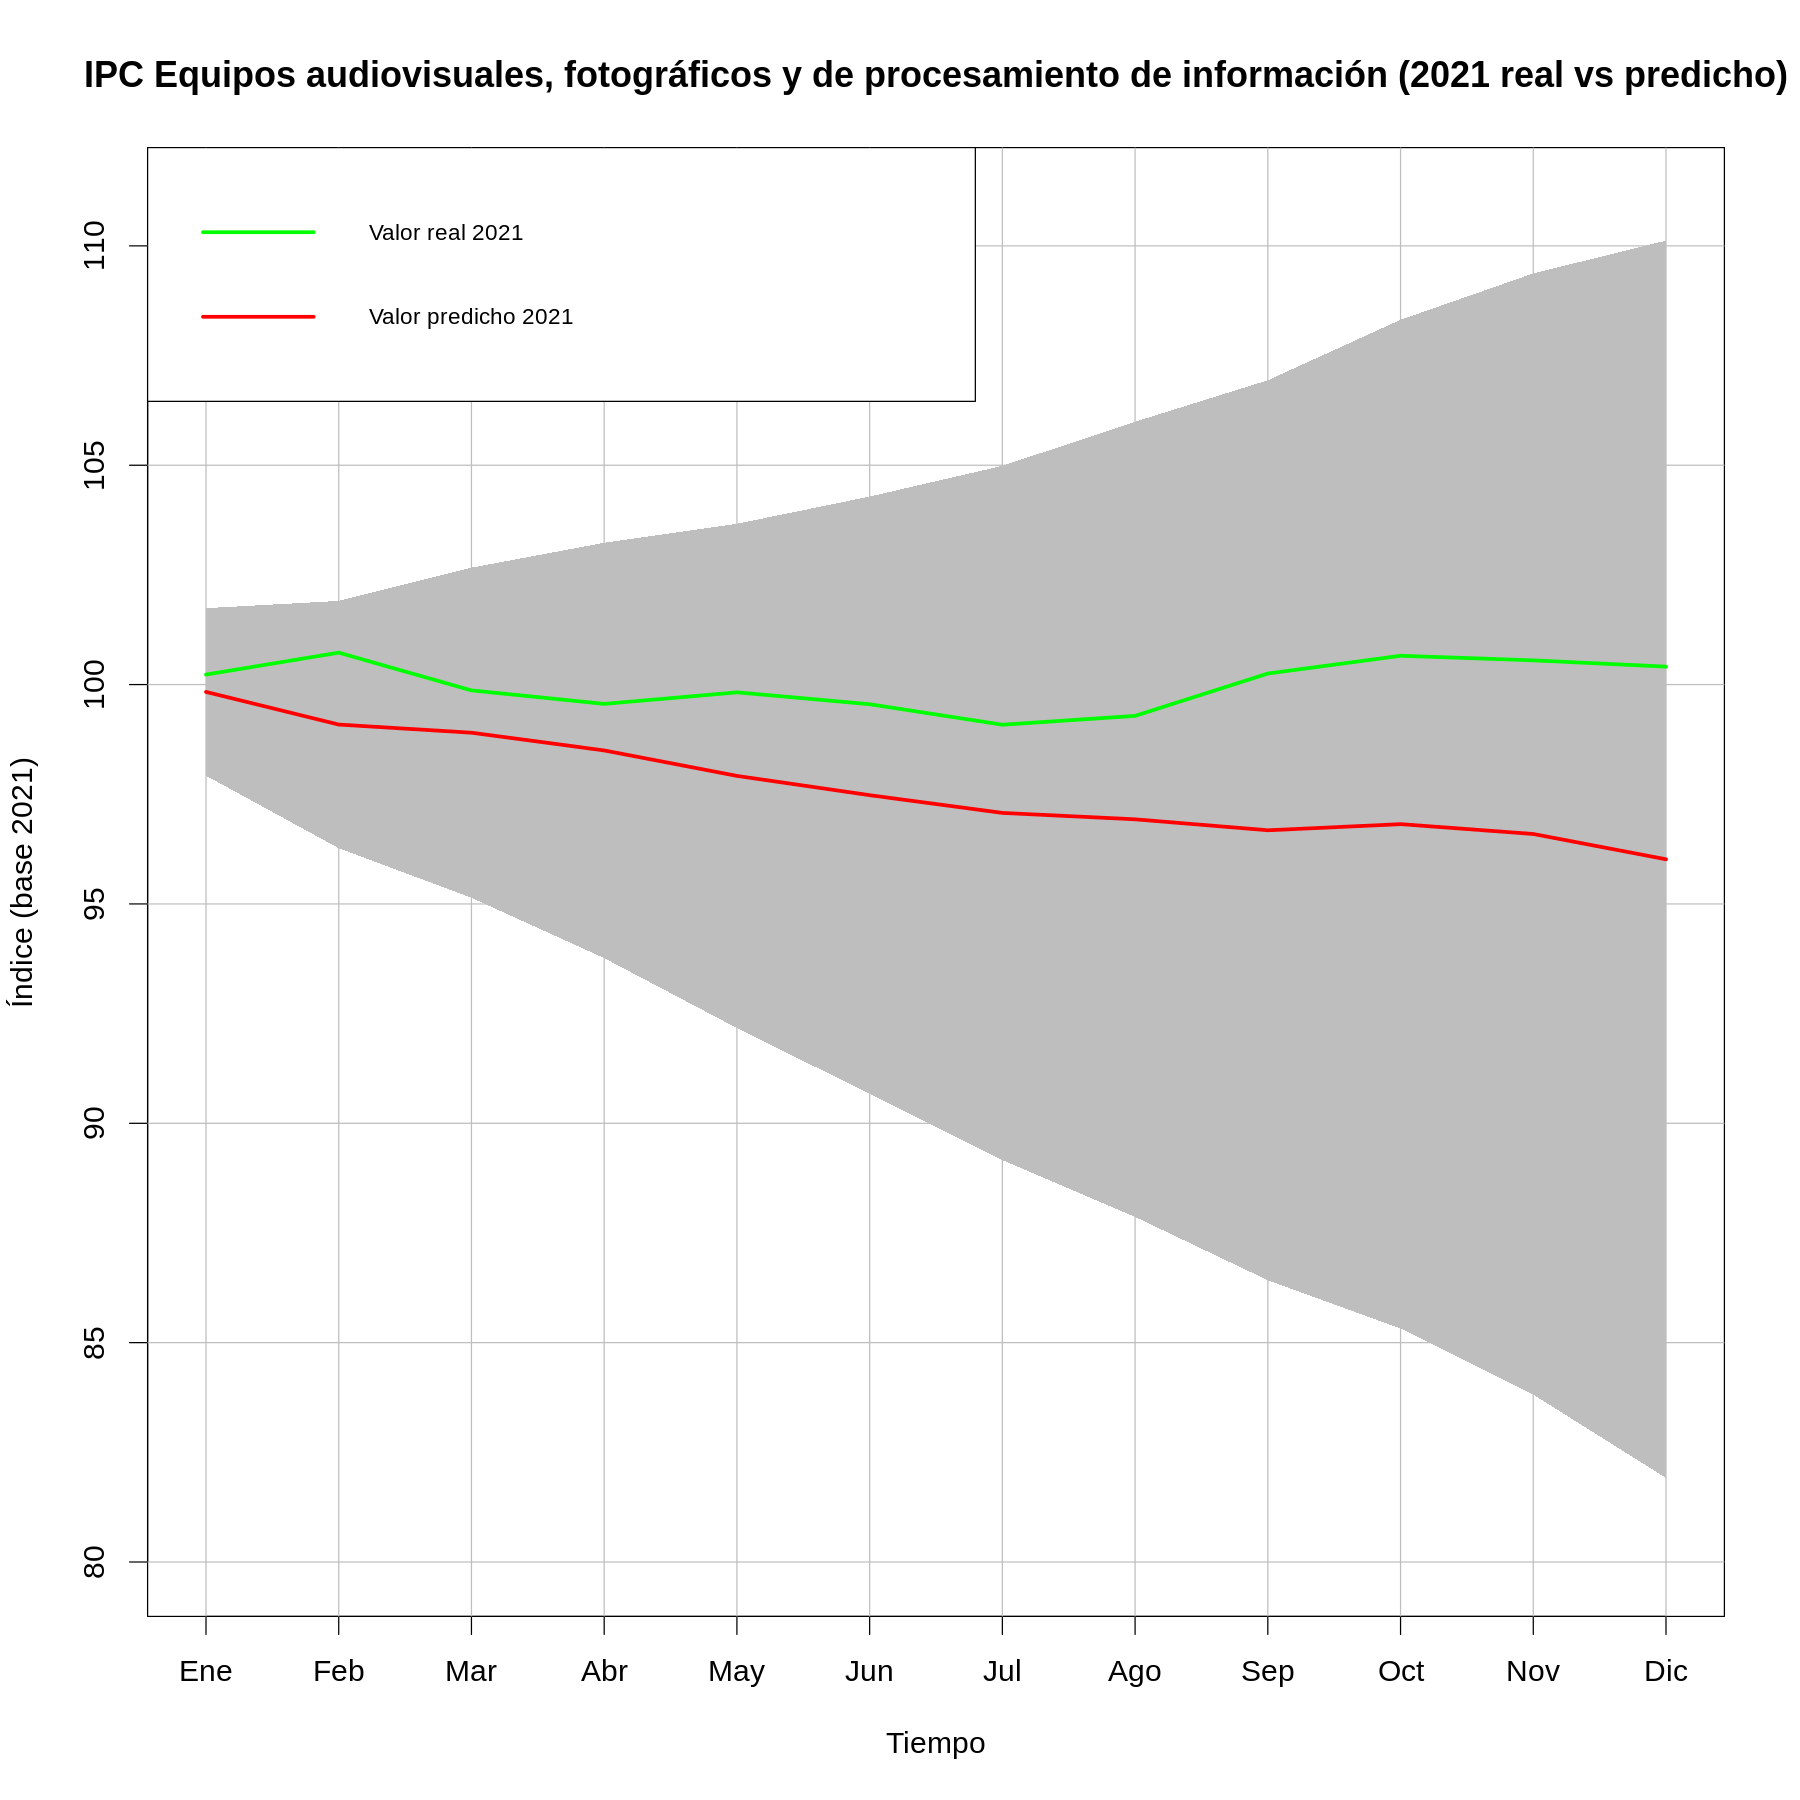

In [ ]:
#Tamaño del gráfico y de las etiquetas:
options(repr.plot.width=15, repr.plot.height=15)
par(cex=1.5)

#Creamos un gráfico vacio con las características de ejes y títulos:
plot(NA,
     xlab="Tiempo", #Título de los ejes
     ylab="Índice (base 2021)", 
     main="IPC Equipos audiovisuales, fotográficos y de procesamiento de información (2021 real vs predicho)", #Título del gráfico
     xlim = c(2021, 2021+11/12),
     ylim = c(80, 111),
     xaxt="n")#Para que el plot() no produzca ticks en el eje X

#Modificamos el eje X (eje 1) para establecer los ticks y las etiquetas donde queramos:
axis(1, at=c(2021, 2021+1/12, 2021+2/12, 2021+3/12, 2021+4/12, 2021+5/12,
             2021+6/12, 2021+7/12, 2021+8/12, 2021+9/12, 2021+10/12, 2021+11/12),
             labels=c("Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"))

#Añadimos una rejilla:
abline(h = c(80, 85, 90, 95, 100, 105, 110), #Líneas horizontales de la rejilla
       v = c(2021, 2021+1/12, 2021+2/12, 2021+3/12, 2021+4/12, 2021+5/12,
             2021+6/12, 2021+7/12, 2021+8/12, 2021+9/12, 2021+10/12, 2021+11/12), #Líneas verticales de la rejilla
       col = "grey")

#Graficamos el intervalo de confianza de las predicciones (debemos usar la función polygon()):
tiempo <- seq(from=2021, by=1/12, length=12)
polygon(x=c(tiempo, rev(tiempo)),
        y=c(Prediccion_2021_IPC_Tecnologia[, "Confint_Superior"], rev(Prediccion_2021_IPC_Tecnologia[, "Confint_Inferior"])),
        col="grey", border=NA)

#Graficamos la serie de 2019:
lines(Serie_IPC_Tecnologia_2021,
      col="green", lwd=3)

#Graficamos las predicción
lines(Prediccion_2021_IPC_Tecnologia[, "Valores_Predichos"],
      col="red", lwd=3)

#Añadimos la leyenda
legend(x = "topleft",
       legend=c("Valor real 2021", "Valor predicho 2021"),
       lty=c(1, 1),
       col=c("green", "red"),
       lwd=3,
       cex=0.75)

En este caso, los valores predichos se encuentran por debajo de los reales. Esto se debe a que el periodo base del índice IPC se sitúa en 2021, por lo que los valores reales se sitúan en torno a 100 (base del índice), mientras que, siguiendo la tendencia a la baja de la serie, las predicciones también presentan una tendencia decreciente.

####**Comparación de los tres modelos vistos**

Para comparar la bondad del ajuste de la predicción a los datos reales en cada uno de los tres modelos obtenidos, vamos utilizar la función `accuracy()` del paquete `forecast`. De las métricas que nos aporta, fijémonos, para simplificar, en:
* MAE (*Mean Absolute Error*): media entre las diferencias absolutas entre los valores predichos y los reales. Cuanto menor su valor, mejor será el modelo.
* MAPE (*Mean Absolute Percentage Error*): proporción de la media de las diferencias entre los valores predichos y los reales, dividido entre su verdadero valor. Cuanto menor su valor, mejor será el modelo.
* RMSE (*Root Mean Squared Error*): raíz de la media de los errores al cuadrado. Cuanto más cerca de cero esté su valor, mejor.

In [ ]:
accuracy(Prediccion_2019_PIB_NO_ajustado[,"Valores_Predichos"], Serie_PIB_NO_ajustados_2019)
accuracy(Prediccion_2019_PIB_SI_ajustado[,"Valores_Predichos"], Serie_PIB_SI_ajustados_2019)
accuracy(Prediccion_2021_IPC_Tecnologia[,"Valores_Predichos"], Serie_IPC_Tecnologia_2021)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.5640593,1.312152,1.24405,-0.1744853,0.4018849,0.1527541,0.08210505


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-2.8275,3.058064,2.8275,-0.9060378,0.9060378,0.2712042,1.374327


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,2.347399,2.659621,2.347399,2.344714,2.344714,0.6637825,5.684069


Como podemos comprobar al atender a dichas tres métricas, el modelo del PIB entrenado con los datos NO ajustados es el que mejores predicciones consigue.